<center><h1>ECSE 443: Introduction to Numerical Analysis in Electrical Engineering</h1></center>
<center><h3>Assignment 3: Convolution and Deconvolution</h3></center>
<center><h3>Due: April 6<sup>th</sup>, 2020 at 11:59pm EST on [myCourses](https://mycourses2.mcgill.ca/)</h3></center>
<center><h3>Final weight: <i>15%</i></h3></center>

<u style="font-size:16pt;">Assignment submission process</u>

Download and modify the `ipynb` notebook we provide on myCourses and submit your modified file, renamed according to your student ID, as

<center><font color='red'>`[YourStudentID]`.ipynb</font></center>

For example, if your id is **234567890**, your submission filename should be **234567890.ipynb**.


<div class="alert alert-note" role="alert">
      Every time you submit a new file, your previous submission will be overwritten. You can submit as many times as you like, but we will only grade the last submission. **We will only accept submissions made through myCourses -- please do not e-mail us your assignment**
</div>

<u style="font-size:16pt;">Late policy & Python `import` statements</u>

This assignment is to be completed individually. 

<div class="alert alert-danger" role="alert">
     Late Policy: non-negotiable time-based penalty - 
    You will lose **5% per hour long period** past the deadline.
</div>

We provide all import statements required to complete the assignment.

<div class="alert alert-danger" role="alert">
    `import` Policy: do not use any `import`s other than those we provide.
    Doing so will result in a score of **zero (0%)** on the assignment.
</div>

$\newcommand{\norm}[1]{\left\| #1 \right\|}$
$\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$
$\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}$

# Image Processing as a Convolution

Many common image processing tasks can be expressed as the convolution of a _kernel_ or sequence of kernels -- each of which _may_ vary spatially over the input image domain. We focus on one such application: **depth of field (DoF)**.

DoF is a photographic effect commonly employed in feature films and video games to highlight a subject of interest, e.g., in the foreground. DoF is caused by the geometric optics in a camera's lens system, resulting in objects appearing more -- or less --  in focus depending on their distance to the camera. High-quality DoF effects require costly camera and lens setups, and so smartphones approximate this effect using synthetic computational approaches.


<img src="Data/DoF_natural.jpg" width="600">
<center><b>High-quality</b> depth of field produced by a DSLR camera.</center>

The _form_ of the DoF blurring depends on the geometry of the camera's aperture, resulting in distinct and controllable artistic styles for DoF, commonly referred to as **bokeh**. For example, when the aperture is fully open, the blur shape can appear to be circular, whereas a partially-open aperture may result in a more hexagonal bokeh blur.
    
<table>
    <tr>
        <td><img src="Data/cameraApertureShapes.jpg" width="300"></td>
        <td><img src="Data/bokehCircular.jpg" width="300"></td>
        <td><img src="Data/bokehHex.jpg" width="300"></td>
    </tr>
    <tr>
        <th><center><b>Camera aperture shapes</b></center></th>
        <th><center><b>Bokeh -- Circular aperture</b></center></th>
        <th><center><b>Bokeh -- Hexagonal aperture</b></center></th>
    </tr>
</table>
   
Computational approaches approximate the effects of DoF as an image filtering post-process. One method, which will be the topic of study for this assignment, relies both on an input image to post-process (i.e., to add synthetic DoF effects atop of) *as well as* an additional auxilliary *depth map*: an image that stores the distance from the camera to each object in a scene, at every pixel. Smartphone cameras can generate (approximate) depth maps using computer vision algorithms beyond the scope of this class -- we simply provide you with the depth maps; you don't need to compute them.

<table>
    <tr>
        <td><img src="Data/sceneWithoutDoF.jpg" width="400"></td>
        <td><img src="Data/sceneWithDoF.jpg" width="400"></td>
    </tr>
    <tr>
        <th><center><b>Input image without DoF</b></center></th>
        <th><center><b>Synthetized image with post-process DoF effects</b></center></th>
    </tr>
    <caption><center><b>An example of synthetic depth of field in the Unity Game Engine&copy;</b></center></caption>
</table>


The flow chart below overviews the DoF image filtering post-process: starting from an input image, we first perform a simple contrast sharpening transformation before applying a DoF post-process. The DoF processing relies on our transformed image as well as an (artificially-constructed) depth map image: from the depth map, we determine a spatially-varying aperture shape that we will use to convolve the image with.

![](Data/bokehFlowChart.png)


## Load an image and adjust its contrast **[5 points]**

Images are stored with finite precision (e.g., 8 bits per color channel) and so have only a limited range of unique pixel intensities/colors they can represent. Most common formats, such as PNG or JPG, store information in _low dynamic range_ (LDR) format -- with pixel intensities $\in \{0,1\}$ represented as unnormalized unsigned integer values, e.g., $\in \{0,255\}$. When loading the image data from file, we convert and normalize the 8-bit unsigned integer values to 32-bit floating point values in the appropriate $\{0,1\}$ range.

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to load the necessary libraries.  
</div>

In [1]:
from __future__ import print_function

from numpy import float, uint8
from numpy import array, zeros, ones, identity, eye, pad, arange, mgrid, empty
from numpy.random import rand
from numpy import min, max, sum, prod, sqrt, abs, dot, outer, exp, round, clip, all, allclose, isfinite
from numpy.linalg import norm, svd
from numpy.linalg import solve

from numpy import load

import sys
import threading

from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

try:
    import thread
except ImportError:
    import _thread as thread
try:
    range, _print = xrange, print
    def print(*args, **kwargs):
        flush = kwargs.pop('flush', False)
        _print(*args, **kwargs)
        if flush:
            kwargs.get('file', sys.stdout).flush()
except NameError:
    pass

def quit_function(fn_name):
    # print to stderr, unbuffered in Python 2.
    print('{0} took too long'.format(fn_name), file=sys.stderr)
    sys.stderr.flush() # Python 3 stderr is likely buffered.
    thread.interrupt_main() # raises KeyboardInterrupt

def exit_after(s):
    def outer(fn):
        def inner(*args, **kwargs):
            timer = threading.Timer(s, quit_function, args=[fn.__name__])
            timer.start()
            try:
                result = fn(*args, **kwargs)
            finally:
                timer.cancel()
            return result
        return inner
    return outer

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<div class="alert alert-info" role="alert">
 Edit (optional) and <b>run</b> the following cell to load and convert our input image (optionally resizing it).
</div>

In [2]:
imagePath = "Data/tree.jpg" # Default image path
imageScale = 100            # Image resizing, as a percentage
                            # Tip : decrease this number to reduce compuation time when debugging

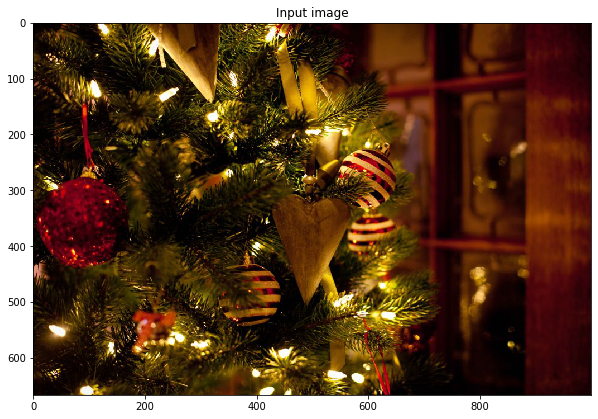

In [3]:
# Load and image and convert to HDR format
def loadImage(path, scale):
    image = Image.open(path, mode = 'r')
    image = image.resize((int(image.width * scale / 100), int(image.height * scale / 100)), resample=Image.LANCZOS)
    image = array(image.getdata()).reshape(image.size[1], image.size[0], 3)
    image = image.astype(float)
    image = image / max(image)
    
    return image

image = loadImage(imagePath, imageScale)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.title("Input image")
plt.show()

The bokeh DoF effect is more pronounced in the presence of sharp contrasts between bright and dark regions in an image. While there are many sophisticated techniques available for image contrast enhancement, we will apply a simple threshold-driven offset to the pixel intensities. Note that this transformation will lead to pixel intensities outside the $\{0,1\}$ range -- this is fine, and commonly referred to as a high dynamic range (HDR) image.

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to set the parameters for our simple image constrast enhancement.
</div>

In [4]:
sharpness = 3   # Any value >= 0
threshold = 0.7 # Any value between 0 and 1

Our contrast enhancement routine simply offsets (i.e., adds) a sharpness offset `s` to the pixel intensity, but only for pixels with intensities greater than some threshold `t`. This offset is applied independently to each color channel.

<div class="alert alert-warning" role="alert">
<b style="color:green;">&#9745;</b> <b>[5 points]</b> Complete the contrast enhancement implementation described above, in the cell below.   
</div>

In [5]:
# Sharpen an HDR image

# inputImg - 3 channel HDR image
# s - sharpness value
# t - threshold value
# returns a contrast-enhanced image

def contrastSharpen(inputImg, s, t):
    # YOUR CODE HERE
    img = inputImg.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(3):
                if img[i, j, k] > t : img[i, j, k] += s
    return img
    #raise NotImplementedError()

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to test your implementation of `contrastSharpen`.  
</div>

In [6]:
# this is a test cell
@exit_after(4)
def testContrastSharpening():
    # load an image
    i0 = loadImage('Data/bokehCircular.jpg', 100)
    
    i0Cpy = i0.copy()
    
    # run student code
    s0 = contrastSharpen(i0, 3, 0.5)
    
    if not allclose(i0Cpy, i0):
        print("You should not modify the input image.")
        return False
    
    # collect test data
    rTest = s0[:, int(i0.shape[1]/2), 0]
    gTest = s0[:, int(i0.shape[1]/4), 1]
    bTest = s0[int(i0.shape[0]/5), :, 2]
    
    # load and compare to reference result
    l0 = load('Data/t0.npz')
        
    return allclose(rTest, l0['r']) and allclose(gTest, l0['g']) and allclose(bTest, l0['b'])

try:
    assert(testContrastSharpening())
    print('Contrast sharpening seems to work!')
except:
    raise Exception("Contrast sharpening is not working... please try again...")

Contrast sharpening seems to work!


<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to display the contrast enhanced image.
</div>

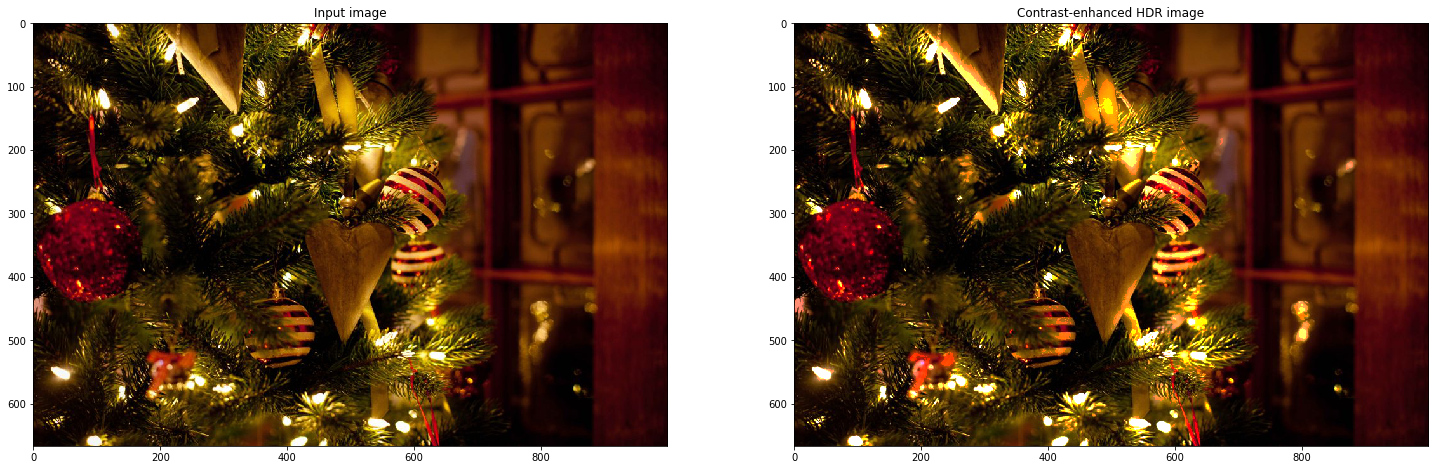

In [7]:
# Convert an HDR image to LDR for presentation
def uintImage(image):
    image = clip(image, 0, 1)
    imMax = max(image)
    if imMax < 1e-5:
        imMax = 1
    image = image / imMax * 255
    return image.astype(uint8)

imageSharpened = contrastSharpen(image, sharpness, threshold)
f, axarr = plt.subplots(1, 2, figsize=(25,10))
axarr[0].imshow(image)
axarr[0].set_title("Input image")
axarr[1].imshow(uintImage(imageSharpened))
axarr[1].set_title("Contrast-enhanced HDR image")
plt.show()

## Generating a synthetic depth map **[0 points]**

Each pixel of the __depth map__ stores the distance of the scene from the camera. We will use this information to derive the spatial size of the convolution filter, at every pixel. For example, we want objects that are further away to be (more) out-of-focus -- and so, we will need to apply a larger filter to them. 

Typical RGB images do not come with an additional depth channel, and so we will rely on an _artificially generated_ depth map based on a 2D Gaussian distribution. Note that our choice here is somewhat arbitrary, as one can choose among many more sophisticated approaches to synthesize depth values from an RGB image (e.g., the image segmentation technique you implemented from A1 could be a good kick-off point for such an approach.)


<div class="alert alert-info" role="alert">
Edit the parameters in the following cell (optional, but encouraged), and <b>run</b> the following __three__ cells, to generate the depth map and get a sense of how the parameters affect its form.
</div>

In [8]:
# Parameters of the anisotropic Gaussian used to 
# generate our synthetic depth map (all values 
# specified as a percentage of the image width/height)

# mean (i.e., "center")
mu_x = 50
mu_y = 50

# standard deviation (i.e., "axis widths")
std_x = 15
std_y = 20

# covariance (i.e., "axis tilt")
cov_xy = 10

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to generate the synthetic depth map.
</div>

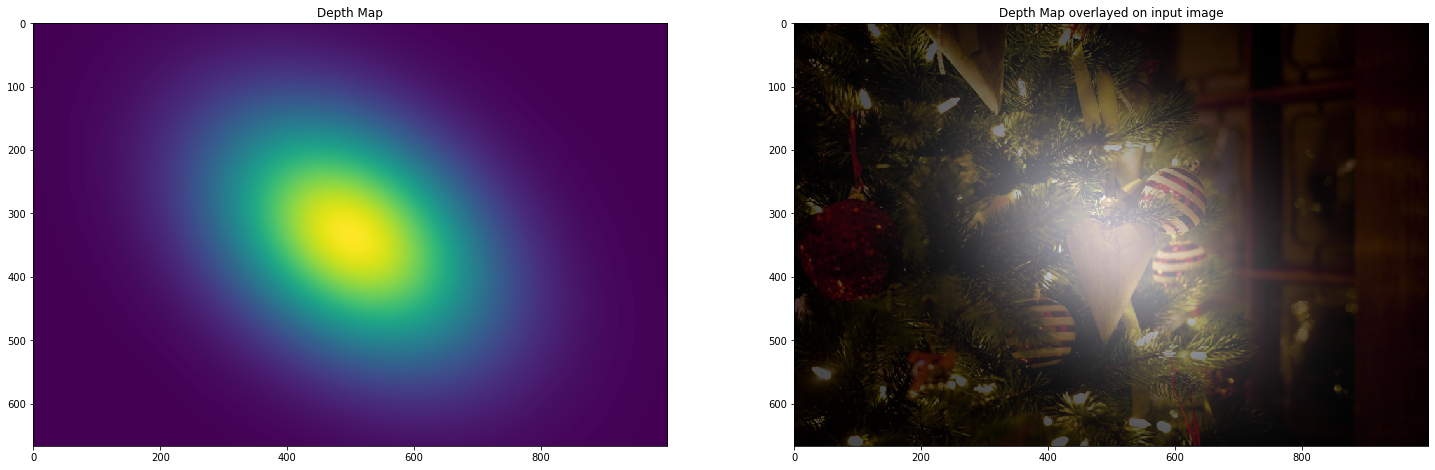

In [9]:
def generateDepthMap(width, height, centerX, centerY, stdX, stdY, covXY):
    x, y = mgrid[0:width, 0:height]
        
    centerX = round(centerX * width / 100.0)
    centerY = round(centerY * height / 100.0)
    stdX = round(stdX * width / 100.0)
    stdY = round(stdY * height / 100.0)
    covXY = round(covXY * ((height * width) ** 0.5) / 100.0)
    
    cov = array([stdX**2, covXY**2, covXY**2, stdY**2]).reshape((2,2))
    mu = array([centerX, centerY])
    
    pos = empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal(mu, cov)
    depthMat = rv.pdf(pos).T
    return  clip(depthMat / max(depthMat), 0, 1)

depthMap = generateDepthMap(image.shape[1], image.shape[0], mu_x, mu_y, std_x, std_y, cov_xy)
overlayDepthOnImage = zeros(image.shape)
for i in range(3):
    overlayDepthOnImage[:,:,i] = 0.4 * image[:,:,i] + depthMap
    overlayDepthOnImage[:,:,i] /= max(overlayDepthOnImage[:,:,i])
f, axarr = plt.subplots(1, 2, figsize=(25,10))
axarr[0].imshow(depthMap)
axarr[0].set_title("Depth Map")
axarr[1].imshow(overlayDepthOnImage)
axarr[1].set_title("Depth Map overlayed on input image")
plt.show()

In a real camera system, the blurring filter size depends not only on the per-pixel depth values, but on camera parameters such as aperture size and distance of the lens to the film. For the purpose of this assignment, however, we use a simplified formulation as provided below -- a more detailed explanation is provided <a href="https://en.wikipedia.org/wiki/Circle_of_confusion">here</a>.

<div class="alert alert-info" role="alert">
<b>Run</b> this cell to define `getFilterRadius`, a function we will use to query the filter size/radius, at a pixel $(x,y)$, depending on that pixel's associated depth value from the depth map.

</div>

In [28]:
# returns the radius of filter
def getFilterRadius(depthMap, x, y, maxFilterRadius):
    filterRadius = round((1.0 - depthMap[y, x]) * maxFilterRadius).astype(int)
    
    # discrete kernel can have a minimum radius of 1
    if (filterRadius <= 0):
        filterRadius = 1
    
    return filterRadius

<div class="alert alert-success" role="alert">
Modify and run the cell below -- several times -- to get a sense of how the filter radius changes as we center it further from the center (i.e., the mean) of our 2D Gaussian depth map distribution.
</div>


In [18]:
# Debugging parameters
x = 500 # horizontal pixel coordinate
y = 350 # vertical pixel coordinate
maxRadius = 25 # Maximum radius of the convolution filter

In [27]:
radius = getFilterRadius(depthMap, x, y, maxRadius)
print("Filter radius at (" + str(x) + "," + str(y) + ") is " + str(radius))

Filter radius at (500,350) is 21



# Depth of Field as a Convolution 

We've preprocessed our input image, generated a (synthetic) depth map for it, and discussed how to query the depth map in order to determine spatially-varying convolution kernel sizes.

Now, we can start implementing the actual spatially-varying convolution!

You will implement several algorithms for spatially-varying convolution using this data. These algorithms will vary both in the __manner__ they compute the convolution, as well as the __type__ of convolution kernels they support:

1. a brute force 2D convolution algorithm applied to spatially-varying symmetric 2D Gaussian kernels,
2. an optimized alternative to method #1 that _perfectly decomposes_ spatially-varying symmetric 2D Gaussian kernels into pairs of spatially-varying 1D Gaussian kernels,
3. an extension of method #2 applied to spatially-varying _asymmetric_ 2D Gaussian kernels, and
4. a general approximation that supports _arbitrary spatially-varying kernels_.

## Brute force convolution with symmetric filters **[15 points]** 

Unlike the majority of convolutions you have likely encountered to date, we will be applying a _spatially-varying_ convolution to our image. Specifically, the size/extent of the convolution filter kernel may not remain constant during convolution; in our case, it varies across each pixel in the input image.

To accomplish this, we will rely on a precomputed set of scaled copies of a base filter kernel, which we generate and store in an array that we refer to as the __filter stack__.

Each filter in the stack is stored as a discretized square image with dimensions varying from $3 \times 3$ up to $101 \times 101$. Note here that we purposefully force the dimension of each filter to be an odd integer, to allow us to center the filter kernel about a pixel (i.e., during convolution) without having fractional kernel pixel offsets.


<img src="Data/filter.png" width="40%"/>

Your first implementation task will use a symmetric 2D Gaussian as the base kernel, and the first step is to generate the filter stack for this base kernel.

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to generate and visualize filters from a __filter stack__ for a symmetric 2D Gaussian base kernel.
 
</div>

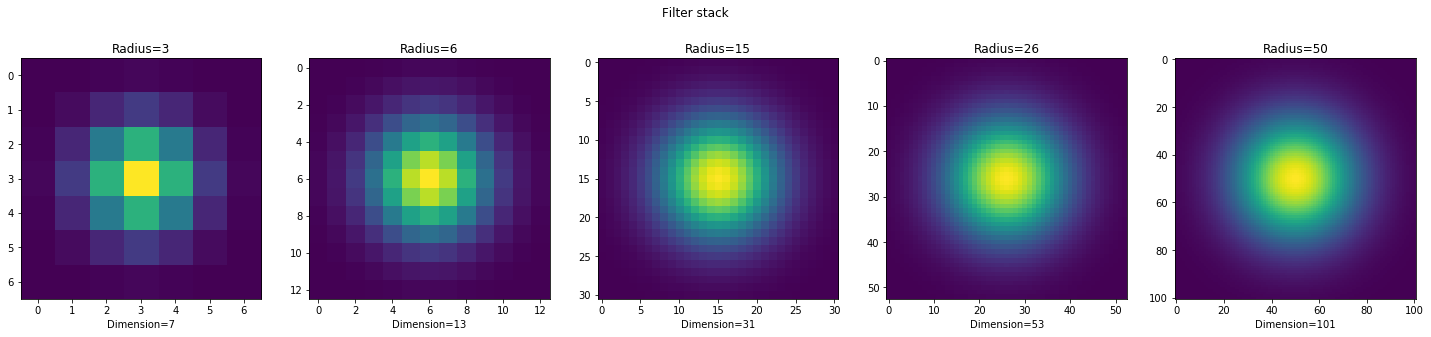

In [20]:
maxFilterRadius = 50

def gauss1D(size):
    ret = arange(-size, size + 1, 1) ** 2
    ret = exp(-ret * 4 / (size * size) )
    return ret / sum(ret)

def generateGauss2DFilterStack(maxFilterSize):
    filters = []
    for radius in range(1, maxFilterSize + 1):
        rawData = gauss1D(radius)
        rawData = outer(rawData, rawData)
    
        filters.append(rawData/ sum(rawData))

    return filters

filterStack = generateGauss2DFilterStack(maxFilterRadius)

def showFilterStack(stack, is1D : bool): 
    f, axarr = plt.subplots(1, 5, figsize=(25,5))
    
    stackIdx = [2, 5, 14, 25, 49]
    
    for i in range(5):
        s = stack[stackIdx[i]]
        if is1D:
            axarr[i].plot(s)
        else:
            axarr[i].imshow(s)
        axarr[i].set_title("Radius=" + str(int(s.shape[0]/2)))
        axarr[i].set_xlabel("Dimension=" + str(int(s.shape[0])))

    f.suptitle("Filter stack")
    plt.show()

showFilterStack(filterStack, False)

You will begin by implementing a __brute force__ spatially-varying convolution routine that explicitly loops over all the pixels and applies the weighted sum of an appropriately-sized filter from the filter stack. The following pseudocode outlines the brute force algorithm:

~~~~~~~~~~~~~~
def conv2d(image, depthMat, maxRadius, kernels):
  imagePadded = pad(image)
  outputImage = np.zeros(image.shape)
  for each pixel p in image:
    r = the desired filter radius for pixel p, queried from the depth map
    for each pixel q in the r-radius neighbourhood around p:
      outputImage(p) += padded image pixel value at q * filter weight at q
~~~~~~~~~~~~~~

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to control the maximum filter radius.
</div>

In [21]:
filterRadius = 25

<div class="alert alert-warning" role="alert">
<b style="color:green;">&#9745;</b><b>[15 Points]</b> Implement the brute force spatially-varying convolution method outlined above, in the cell below.   
</div>

In [29]:
# image - input image
# depthMap - depth values at each pixel
# maxRadius - maximum radius of filter
# stack - a list of 2D filters from radius 1 upto 50
# returns an image convolved using the provided filters
def conv2d(image, depthMap, maxRadius, stack):
    # Hint 0: use numpy.pad() to pad the input image using a median padding mode
    # Hint 1: query the filter radius at pixel (x,y) using getFilterRadius(depthMap, x, y, maxRadius)
    # Hint 2: stack[i] accesses the filter of radius i + 1

    # YOUR CODE HERE
    ## Pad Image
    r0 = 2*maxRadius
    imagePadded = pad(image, ((r0, r0), (r0, r0), (0, 0)), 'median')
    
    ## Initialize Output
    outputImage = zeros(image.shape)
    
    ## for each pixel p in image:
    for x in range(image.shape[0]):
        p1 = x + r0
        for y in range(image.shape[1]):
            p2 = y + r0
            
            ## r = the desired filter radius for pixel p, queried from the depth map
            r = getFilterRadius(depthMap.T, x, y, maxRadius)
            mask = stack[r - 1]
            
            ## for each pixel q in the r-radius neighbourhood around p:
            ## outputImage(p) += padded image pixel value at q * filter weight at q
            ## B = square block of image about pixel of radius r
            B = imagePadded[(p1-r):(p1+r+1), (p2-r):(p2+r+1), :] 
            for d in range(3):
                outputImage[x, y, d] += sum(B[:, :, d]*mask)
    return outputImage
    # raise NotImplementedError()

<div class="alert alert-info" role="alert">
 <b>Run</b> the following cell to test your brute force implementation of `conv2d`. <i>Tip:</i> The difference image should be completely dark for a correct solution.
</div>

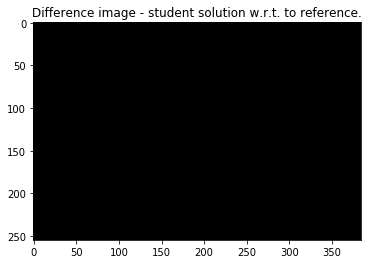

Test passed: congratulations!


In [30]:
# this is a test cell
@exit_after(10)
def testConv2d_0():
    # load an image, generate its depth map and filter stack
    i0 = loadImage('Data/bokehCircular.jpg', 30)
    dM = generateDepthMap(i0.shape[1], i0.shape[0], 50, 25, 15, 20, 10)
    fMs = generateGauss2DFilterStack(50)
    
    # run student code and compare to reference result
    imConv = conv2d(i0, dM, 10, fMs)
    
    l0 = load('Data/t1a.npz')
    diffIm = abs(l0['imC'] - imConv)
    plt.imshow(uintImage(diffIm * 50))
    plt.title("Difference image - student solution w.r.t. to reference.")
    plt.show()
    
    error = sqrt(sum(diffIm**2))
    denom = sqrt(sum(l0['imC']**2))
      
    return error / denom < 0.07
    
try:
    assert(testConv2d_0())
    print('Test passed: congratulations!')
except:
    raise Exception("Test failed: your output differs too much from the reference.")

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to apply your brute force convolution algorithm to generate a synthetic depth of field image with spatially-varying symmetric 2D Gaussian kernels.
</div>

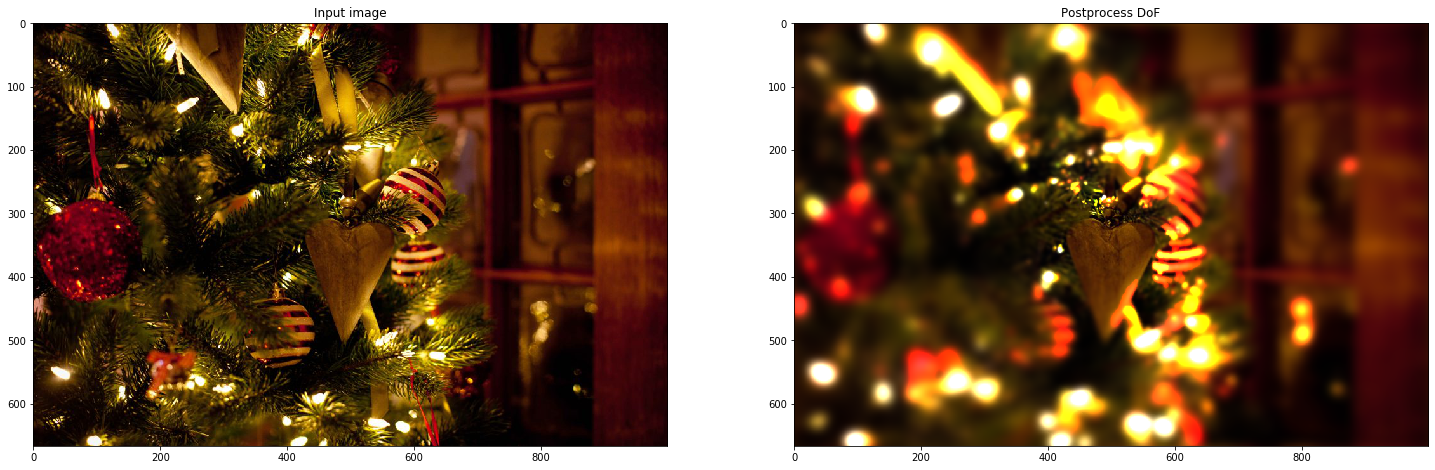

In [31]:
convImage = conv2d(imageSharpened, depthMap, filterRadius, filterStack)

f, axarr = plt.subplots(1, 2, figsize=(25,10))
axarr[0].imshow(image)
axarr[0].set_title("Input image")
axarr[1].imshow(uintImage(convImage))
axarr[1].set_title("Postprocess DoF")
plt.show()

## Separable convolution with symmetric filters **[20 points]**

In the previous task, each kernel in our filter stack is symmetric, which means if we encode the filter weights as a matrix $\mathbf{K}$, its eigendecomposition
$$
\mathbf{K} = \mathbf{V} \mathbf{\Lambda} \mathbf{V}^{-1}
$$
would only yield one non-zero eigenvalue $\lambda_0$.

This suggests that we can _decompose_ the matrix $\mathbf{K}$ as the outer-product of two 1D vectors as
$$
\mathbf{K} = \lambda_0 \mathbf{v}_0 \mathbf{v}_0^{T}~,
$$
and so we could analogously decompose the 2D symmetric Gaussian base kernel as the (outer functional) product of two 1D (obviously symmetric) Gaussians.

Let's start by validating this decomposition for a single 2D symmetric base kernel, before computing 1D filter stacks for the 2D base kernel. Here, we won't yet employ any eigendecomposition, but instead operate entirely in the functional setting.


<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to visualize the outer product of two 1D Gaussian base kernels.
</div>

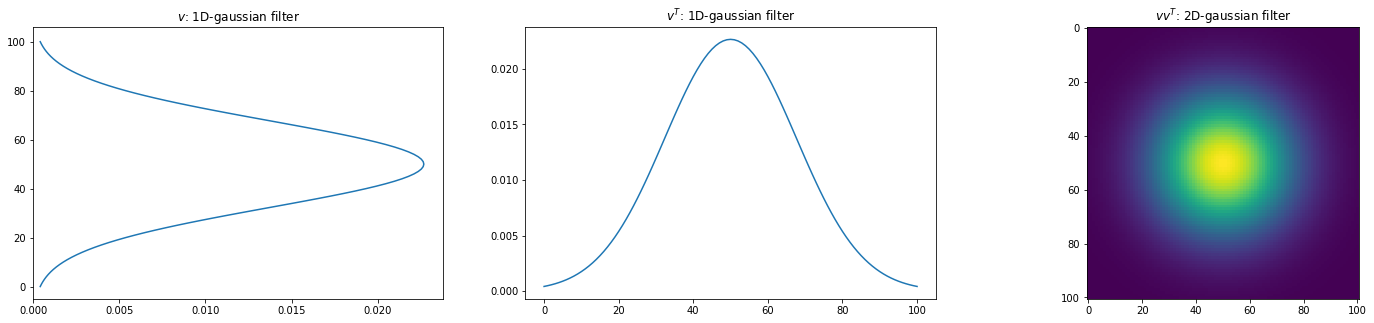

In [32]:
filterGauss1D = gauss1D(maxFilterRadius)
filterGauss2D = outer(filterGauss1D, filterGauss1D)

f, axarr = plt.subplots(1, 3, figsize=(25,5))
axarr[0].plot(filterGauss1D)
f.canvas.draw()
newx = axarr[0].lines[0].get_ydata()
newy = axarr[0].lines[0].get_xdata()
axarr[0].lines[0].set_xdata(newx)
axarr[0].lines[0].set_ydata(newy)
axarr[0].set_xlim([0, 1.05 * max(filterGauss1D)])
axarr[0].set_ylim([-5, filterGauss1D.shape[0] + 5])
axarr[0].set_title("$v$: 1D-gaussian filter")
axarr[1].plot(filterGauss1D)
axarr[1].set_title("$v^T$: 1D-gaussian filter")
axarr[2].imshow(filterGauss2D)
axarr[2].set_title("$vv^T$: 2D-gaussian filter")
plt.show()

Analogously to the 2D scenario, we can generate the filter stacks for 1D Gaussian kernels of varying size.

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to generate and visualize the 1D Gaussian filter stack.
</div>

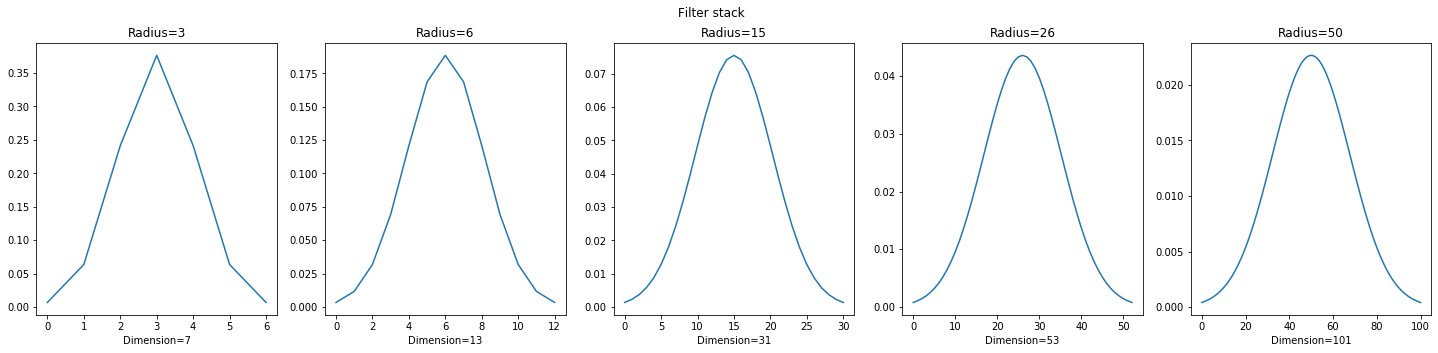

In [33]:
def generateGauss1DFilterStack(maxFilterSize):
    filters = []
    for radius in range(1, maxFilterSize + 1):
        rawData = gauss1D(radius)
        rawData /= sum(rawData)
        filters.append(rawData)

    return filters

filterStack1D = generateGauss1DFilterStack(maxFilterRadius)
showFilterStack(filterStack1D, True)

The linearity of the eigendecomposition, as well as the linearity of our convolution, implies that our 2D spatially-varying convolution can be reduced to the application of two 1D spatially-varying convolutions: one along the horizontal image axis and one along the vertical axis.

The computational complexity of the brute force 2D convolution _with a fixed radius kernel_ (i.e., not spatially-varying) is $\mathcal{O}(mnw^2)$ for an $m \times n$ input image and a single kernel of width $w$. In the case of a symmetric kernel, only two 1D convolutions are needed to generate the same result as the 2D convolution, and so the assymptotic cost reduces to $\mathcal{O}(mnw)$.

As such, decomposing a 2D convolution procedure into multiple 1D convolution passes can lead to significant performance gains, especially as the kernel width grows.

Specifically, we will perform this two-pass 1D convolution process by: 
1. perform a 1D horizontal spatially-varying convolution,
2. transpose the image,
3. perform a second horizontal spatially-varying 1D convolution, and
4. transpose the image back to its original orientation.
<img src="Data/1DConv.png"/>

Following is the pseudo-code for spatially varying 1D convolution:

You'll start by first implementing a procedure to perform a brute force 1D convolution along the horizontal axis. This routine will resemble your brute force `conv2d` routine, except now your inner-most loop will only consider a horizontal pixel neighbourhood.


<div class="alert alert-warning" role="alert">
    <b style="color:green;">&#9745;</b><b> [15 Points]</b> Implement a brute force spatially-varying 1D horizonal convolution.
</div>

In [36]:
# image - input image
# depthMap - depth values at each pixel
# maxRadius - maximum radius of filter
# stack - a list of 1D filters from radius 1 upto 50
# returns an image convolved using the provided filters
def conv1d(image, depthMap, maxRadius, stack):
    # Hint 0: use numpy.pad() to pad the input image with median padding mode
    # Hint 1: query the filter radius at pixel (x,y) using getFilterRadius(depthMap, x, y, maxRadius)
    # Hint 2: stack[i] accesses the filter of radius i + 1
  
    # YOUR CODE HERE
    r0 = 2*maxRadius
    paddedImage = pad(image, ((r0, r0), (r0, r0), (0, 0)), 'median')
    outputImage = zeros(image.shape)
       
    for x in range(image.shape[0]):
        p1 = x + r0
        for y in range(image.shape[1]):
            p2 = y + r0
            
            ## r = the desired filter radius for pixel p, queried from the depth map
            r = getFilterRadius(depthMap.T, x, y, maxRadius)
            mask = stack[r - 1]
            
            ## for each pixel q in the r-radius neighbourhood around p:
            ## outputImage(p) += padded image pixel value at q * filter weight at q
            ## B = square block of image about chosen pixel of radius r
            B = paddedImage[p1, (p2-r):(p2+r+1), :] 
            for d in range(3):
                outputImage[x, y, d] += sum(B[:, d]*mask)
    return outputImage
    # raise NotImplementedError()

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to test your implementation of `conv1d`. <i>Tip:</i> The difference image should be completely dark for a correct solution. 
</div>

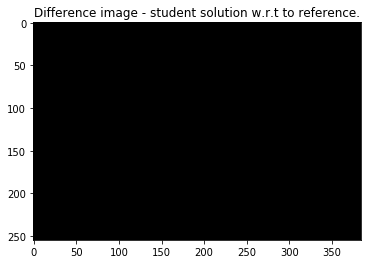

Test passed: congratulations!


In [37]:
# this is a test cell
@exit_after(9)
def testConv1d(testAbs : bool):
    # load an image, generate a depth map, and create our filter stack
    i0 = loadImage('Data/bokehCircular.jpg', 30)
    dM = generateDepthMap(i0.shape[1], i0.shape[0], 50, 25, 15, 20, 10)
    fMs = generateGauss1DFilterStack(50)
    
    # run student code and compare to reference
    imConv = conv1d(i0, dM, 10, fMs)
    
    l0 = load('Data/t2.npz')
    diffIm = abs(l0['imC'] - imConv)
    plt.imshow(uintImage(diffIm * 50))
    plt.title("Difference image - student solution w.r.t to reference.")
    plt.show()
    
    if testAbs:
        return allclose(l0['imC'], imConv)
   
    error = sqrt(sum(diffIm**2))
    denom = sqrt(sum(l0['imC']**2))
      
    return error / denom < 0.07
    
try:
    assert(testConv1d(False))
    print('Test passed: congratulations!')
except:
    raise Exception("Test failed: your output differs too much from the reference.")

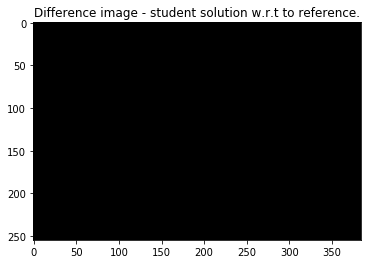

Test passed: good job


In [38]:
# this is a test cell
try:
    assert(testConv1d(True))
    print('Test passed: good job')
except:
    raise Exception("Test failed: individual pixels do not match closely with the reference.")

Now that we can perform a horizonal 1D spatially-varying convolution, let's code up a routine to transpose our image (before eventually applying the 1D convolution again, to the transposed image.)

<div class="alert alert-warning" role="alert">
<b style="color:green;">&#9745;</b> <b>[5 Points]</b> Implement a routine to transpose a 3-channel RGB image.    
</div>

In [39]:
# inImage - 3 channel input image
# return transpose of the image
def transposeImage(inImage):
    # Hint 0: if the input has size (h,w,3)
    # then the output should have size (w,h,3)
    
    # YOUR CODE HERE
    size = inImage.shape
    outImage = zeros((size[1], size[0], 3))
    # YOUR CODE HERE
    for x in range(size[0]):
        for y in range(size[1]):
            outImage[y, x, :] = inImage[x, y, :]
    return outImage
    # raise NotImplementedError()

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to test your implementation of `transposeImage`.  
</div>

In [40]:
@exit_after(2)
def testTransposeImage():
    im = rand(10, 8, 3)
    # run student code
    imT = transposeImage(im)
    
    success = True
    
    for ch in range(3):
        for r in range(10):
            for c in range(8):
                if im[r,c,ch] != imT[c,r,ch]:
                    success = False
    
    return success

try:
    assert(testTransposeImage())
    print('Perfect - works as expected!')
except:
    raise Exception("Your transpose is not transposing... give it another shot...")

Perfect - works as expected!


We finally have all the pieces needed to complete our end-to-end 2D convolution, leveraging the 1D outer-product decomposition of our symmetric kernels.

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to perform two passes of 1D convolution.
</div>

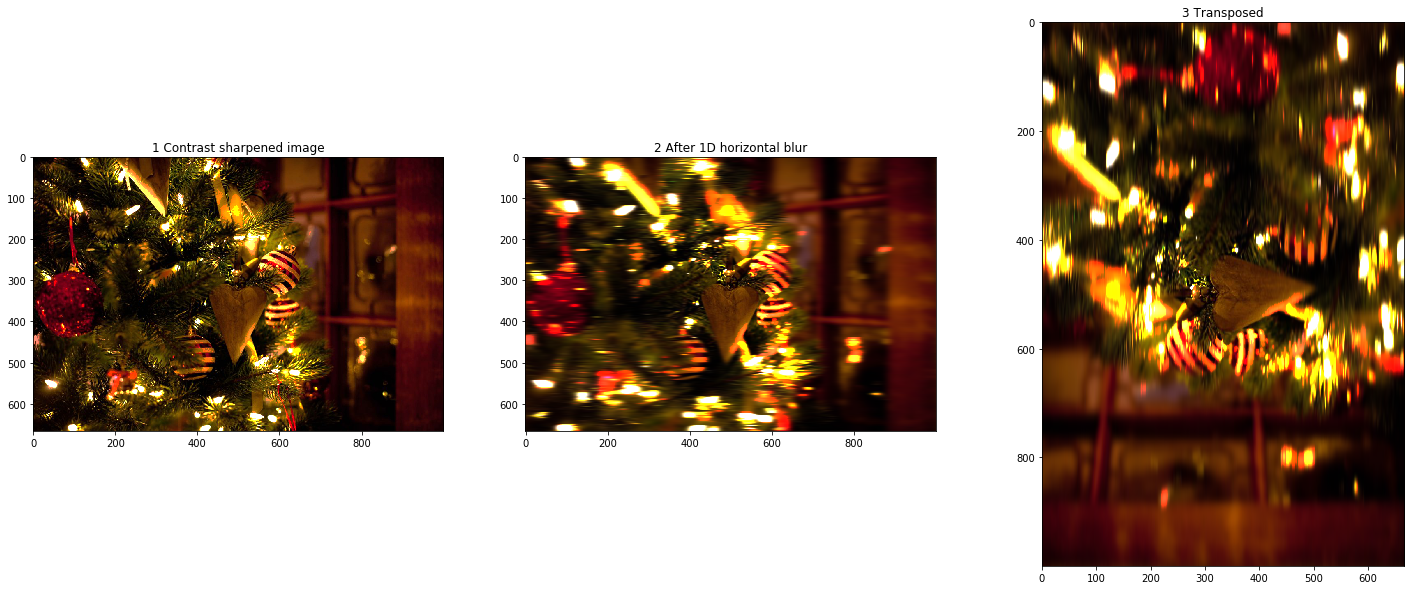

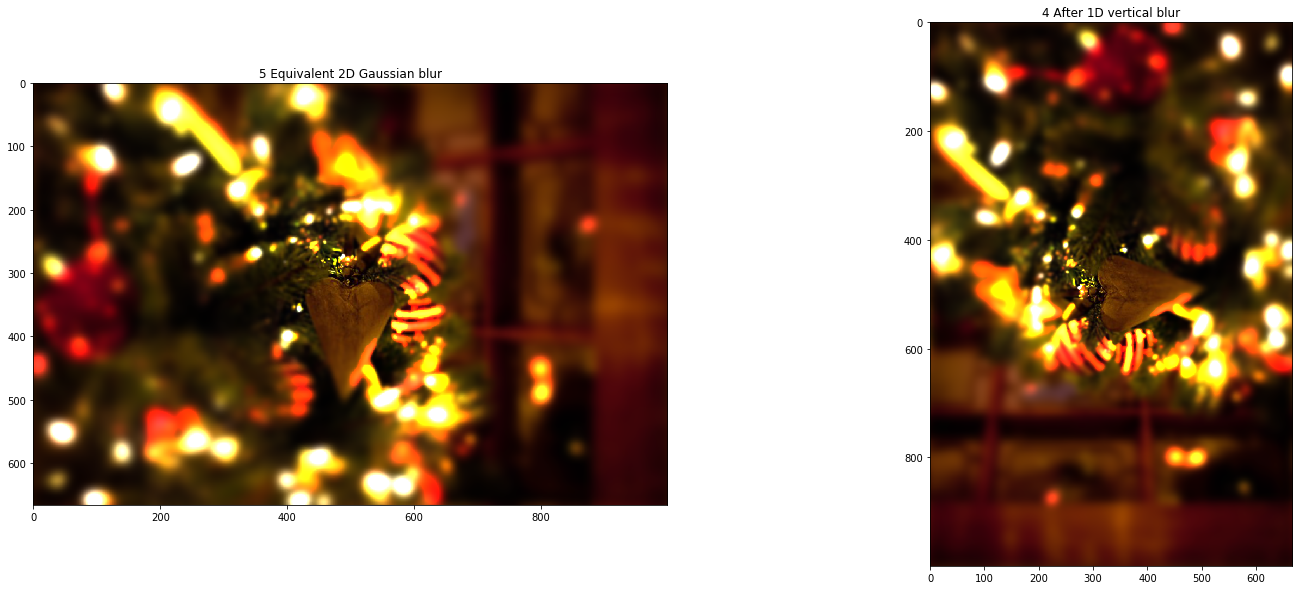

In [45]:
ih = conv1d(imageSharpened, depthMap, filterRadius, filterStack1D)
ihT = transposeImage(ih)
ivT = conv1d(ihT, depthMap.T, filterRadius, filterStack1D)
gaussianBlurImage = transposeImage(ivT)

f, axarr = plt.subplots(1, 3, figsize=(25,10))
axarr[0].imshow(uintImage(imageSharpened))
axarr[0].set_title("1 Contrast sharpened image")
axarr[1].imshow(uintImage(ih))
axarr[1].set_title("2 After 1D horizontal blur")
axarr[2].imshow(uintImage(ihT))
axarr[2].set_title("3 Transposed")
plt.show()
f, axarr = plt.subplots(1, 2, figsize=(25,10))
axarr[1].imshow(uintImage(ivT))
axarr[1].set_title("4 After 1D vertical blur")
axarr[0].imshow(uintImage(gaussianBlurImage))
axarr[0].set_title("5 Equivalent 2D Gaussian blur")
plt.show()

## Separable convolution with asymmetric filters **[20 points]**

We previously leveraged the fact that the eigendecomposition of our symmetric kernel matrix $\mathbf{K}$ suggested a simple product-of-1D-functions decomposition. We didn't actually compute the eigendecomposition, and instead relied on the functional form of the 2D and 1D Gaussians to validate this decomposition and use it to accelerate our 2D spatially-varying convolution.

The next two tasks will continue to explore this avenue, but now relying explicitly on SVDs in order to compute decompositions of increasingly complex base kernels:
- first, a 2D Gaussian base kernel, but now one that is __asymmetric__, and then
- an arbitrary blur kernel -- specified as a bitmap image -- meant to better represent real-world kernels you would encounter in a physical camera system.

For an asymmetric 2D Gaussian base kernel $\mathbf{K}$, we will construct the following rank-1 approximation of a filter using the SVD:
$$
\mathbf{K} = \sum_i \mu_i \mathbf{u}_i \mathbf{v}_i^T \approx \mu_0 \mathbf{u}_0 \mathbf{v}_0^T \equiv \overline{\mathbf{K}}~,
$$
where,
$\mathbf{K}$ is the original 2D asymmetric Gaussian kernel encoded as a matrix, $\{\mathbf{u}_i~, \mathbf{v}_i\}$ are its left and right singular vectors, $\mu_i$ their associated singular values, and $\overline{\mathbf{K}}$ the rank-1 approximation of our base kernel.



<div class="alert alert-info" role="alert">
<b>Run</b> and edit (optional) the following cell to change the asymmetry of our base 2D Gaussian kernel.
</div>

In [46]:
filterSkewFactor = 0.0  # Between -1 (max-skew) and 1 (max-skew)
filterDegenFactor = 0.2 # Between 0 (degenerate) and 1 (non-degenerate)

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to generate an asymmetric 2D Gaussian base kernel.
</div>

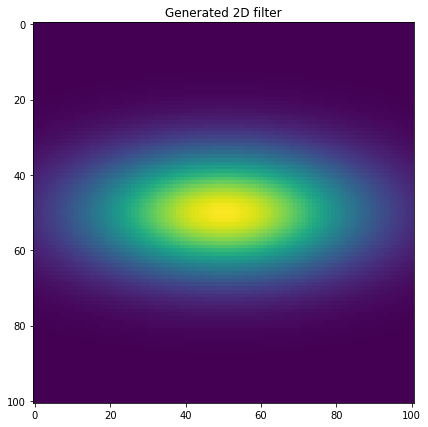

In [47]:
def gauss2d(filterSize, skewFactor, degenFactor):
    x, y = mgrid[-filterSize:filterSize + 1, -filterSize:filterSize + 1]
    
    basis = array([skewFactor, sqrt(1 - skewFactor**2)])
    eigVec = array([basis[0], -basis[1], basis[1], basis[0]]).reshape(2, 2)
    eigVal = array([(filterSize/2)**2, 0, 0, (filterSize/2)**2 * degenFactor]).reshape(2,2)
    
    cov = dot(dot(eigVec, eigVal), eigVec.T)
    mu = array([0, 0])
    
    pos = empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal(mu, cov)
    filter = rv.pdf(pos)
    
    return filter / sum(filter) 

gauss2DFilter = gauss2d(maxFilterRadius, filterSkewFactor, filterDegenFactor)
plt.figure(figsize=(7,7))
plt.imshow(uintImage(gauss2DFilter))
plt.title("Generated 2D filter")
plt.show()

In order to compute the rank-1 approximation $\overline{\mathbf{K}}$ of this base kernel $\mathbf{K}$, you will implement the **power iteration** algorithm.

The power iteration algorithm, in its simplest form, can be used to compute the eigenvector associated to the largest eigenvalue of a square matrix. The algorithm converges when the matrix has a single dominant eigenvalue, which happens to be the case for our current example.<!--for this 2D asymmetric Gaussian base kernel.-->

Here is some pseudocode to guide your power iteration implementation:

~~~~~~~~~~~~~~
def powerIteration(A, numIter):
  eVector = random vector of appropriate size for our square matrix input A
  for numIter iterations, repeat:
    eVector = A * eVector
    normalize eVector
  return eVector
~~~~~~~~~~~~~~

<div class="alert alert-warning" role="alert">
<b style="color:green;">&#9745;</b> <b>[10 Points]</b> Implement the power iteration algorithm to return the dominant eigenvector for a given square matrix `A`. 
</div>

In [48]:
# A - square symmetric matrix
# numIter - Number of iterations
def powerIteration(A, numIter):
    # YOUR CODE HERE
    eVector = rand(A.shape[0])
    for _ in range(numIter):
        eVector = A.dot(eVector)
        eVector /= norm(eVector)
    return eVector
    # raise NotImplementedError()

Once you have a power iteration algorithm, you can compute the left and right singular vectors $\{\mathbf{u}_0~,\mathbf{v}_0\}$ associated to the largest singular value $\mu_0$ for our rank-1 approximation $\overline{\mathbf{K}}$ by applying the power iteration on $\mathbf{K}\mathbf{K}^T$ and $\mathbf{K}^T\mathbf{K}$.

<div class="alert alert-warning" role="alert">
    <b style="color:green;">&#9745;</b> <b>[5 Point]</b> Complete the implementation of the routine below that computes and returns the dominant left and right singular vectors.
</div>

In [49]:
# K - The 2D convolution kernel matrix
# numIter - number of iterations (argument for powerIteration)
# return u,v - i.e. left and right singular vectors for K 
def dominantSingularVectors(K, numIter):
    # YOUR CODE HERE
    KT = K.T
    A = K @ KT
    u = powerIteration(A, numIter)
    B = KT @ K
    v = powerIteration(B, numIter)
    return u, v
    # raise NotImplementedError()

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to test your implementation of 'dominantSingularVectors'. 
</div>

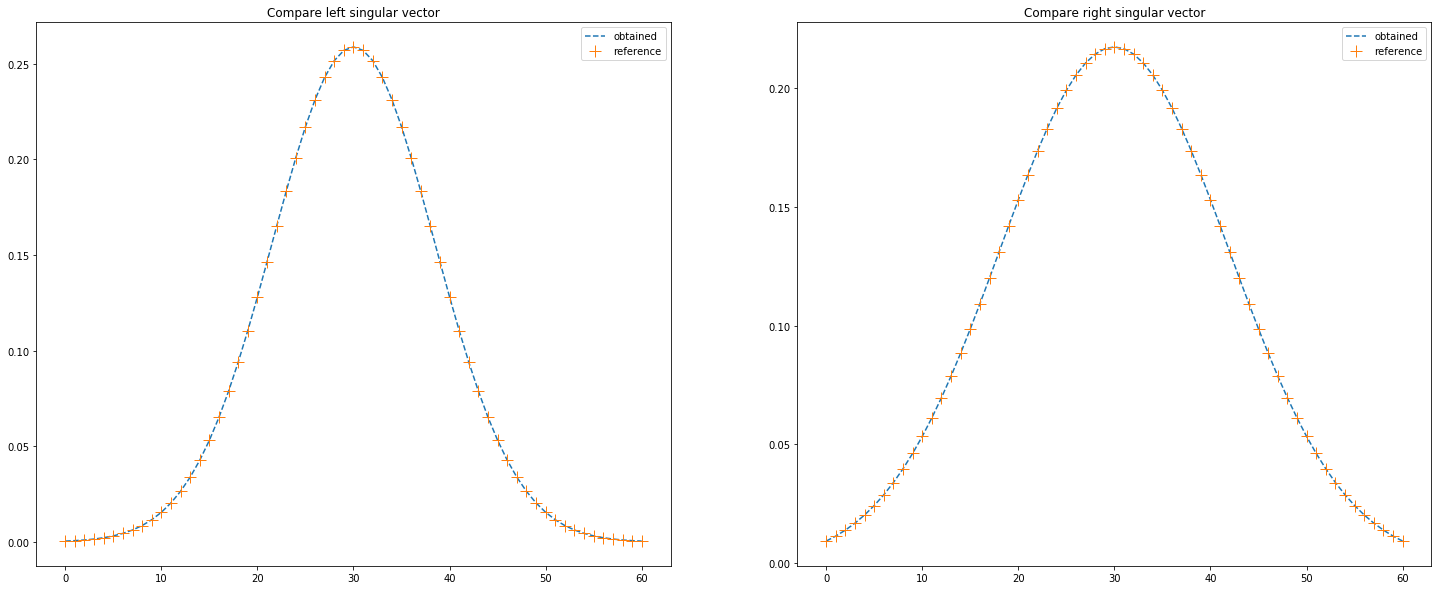

Perfect - works as expected!


In [50]:
@exit_after(3)
def testDominantSingularVectors():
    K = gauss2d(30, 0.5, 0.2)
    
    # run student code
    u, v = dominantSingularVectors(K, 10)
        
    l0 = load('Data/t3.npz')
    
    if l0['u'].shape != u.shape:
        print("Shape of left singularvectors is incorrect!")
        print("Returned shape is - " + str(u.shape))
        print("Expected shape is - " + str(l0['u'].shape))
        return False
    
    if l0['v'].shape != v.shape:
        print("Shape of right singularvectors is incorrect!")
        print("Returned shape is - " + str(v.shape))
        print("Expected shape is - " + str(l0['v'].shape))
        return False
    
    f, axarr = plt.subplots(1, 2, figsize=(25,10))
    axarr[0].plot(u, '--', label='obtained')
    axarr[0].plot(l0['u'], '+', label='reference', markersize=12)
    axarr[0].set_title('Compare left singular vector')
    axarr[0].legend()
        
    axarr[1].plot(v, '--', label='obtained')
    axarr[1].plot(l0['v'], '+', label='reference', markersize=12)
    axarr[1].set_title('Compare right singular vector')
    axarr[1].legend()
    plt.show()
    
    return allclose(l0['u'], u) and allclose(l0['v'], v)

try:
    assert(testDominantSingularVectors())
    print('Perfect - works as expected!')
except:
    raise Exception("Your dominant singular vectors do not seem to be correct")

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to visualize the left and right singular vector decomposition overlayed atop the original 2D base kernel $\mathbf{K}$.
</div>

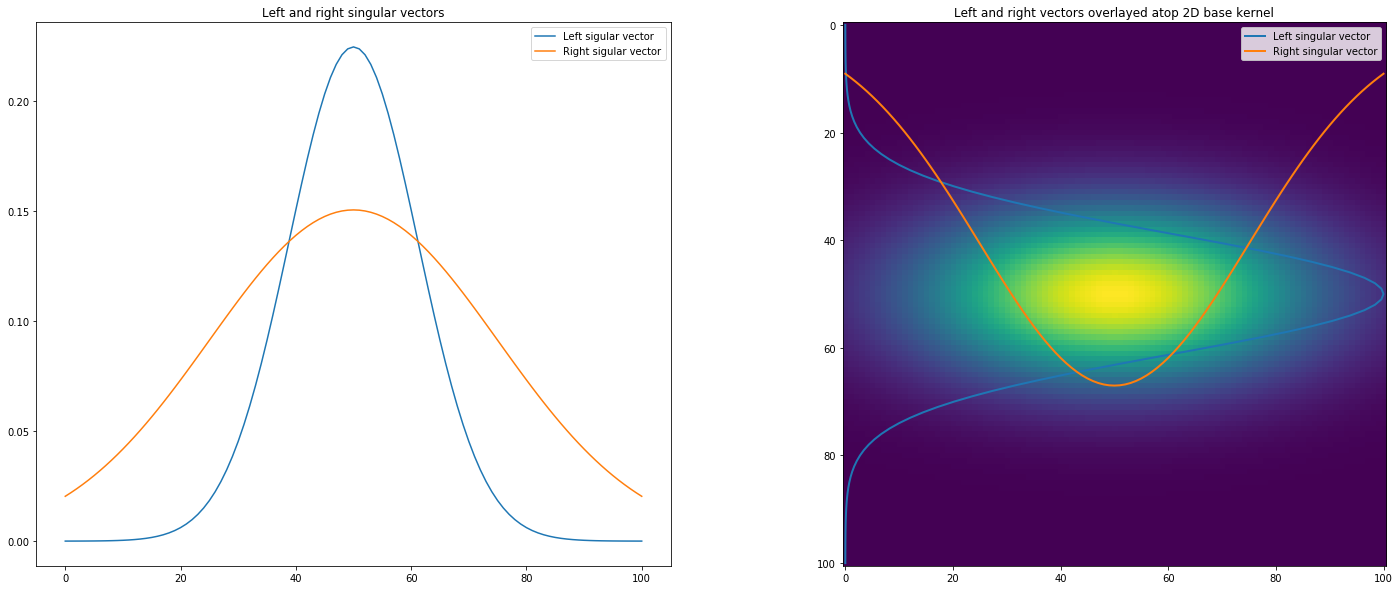

In [51]:
leftSingular, rightSingular = dominantSingularVectors(gauss2DFilter, 10)

f, axarr = plt.subplots(1, 2, figsize=(25,10))
axarr[0].plot(leftSingular, label="Left sigular vector")
axarr[0].plot(rightSingular, label="Right sigular vector")
axarr[0].set_title("Left and right singular vectors")
axarr[0].legend()
axarr[1].imshow(gauss2DFilter)
f.canvas.draw()
maxOfTwo = max(array([max(leftSingular), max(rightSingular)]))
axarr[1].plot(leftSingular / maxOfTwo * maxFilterRadius * 2, label="Left singular vector", linewidth=2)
f.canvas.draw()
newx = axarr[1].lines[0].get_ydata()
newy = axarr[1].lines[0].get_xdata()
axarr[1].lines[0].set_xdata(newx)
axarr[1].lines[0].set_ydata(newy)
axarr[1].plot(rightSingular / maxOfTwo * maxFilterRadius * 2, label="Right singular vector", linewidth=2)
axarr[1].legend()
axarr[1].set_title("Left and right vectors overlayed atop 2D base kernel")
plt.show()

We've completed a rank-1 approximation of our base asymmetric 2D Gaussian blurring kernel. Let's now generate the filter stacks: one 2D filter stack for the original $\mathbf{K}$, and one 1D filter stack using our rank-1 approximation $\overline{\mathbf{K}}$.

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to generate and visualize the 2D filter stack for our asymmetric 2D Gaussian base kernel.
</div>

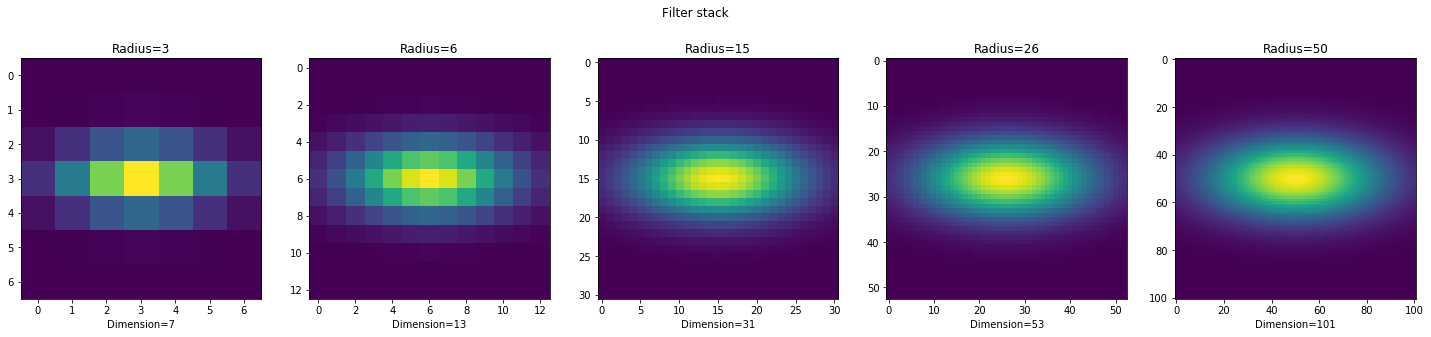

In [52]:
# Generate skewed/asymmetric Gaussian filter stack
def generateAsymGauss2DFilterStack(maxFilterSize, skewFactor, degenFactor):
    filters = []
    for radius in range(1, maxFilterSize + 1):
        rawData = gauss2d(radius, skewFactor, degenFactor)
        filters.append(rawData)

    return filters

filterStack = generateAsymGauss2DFilterStack(maxFilterRadius, filterSkewFactor, filterDegenFactor)
showFilterStack(filterStack, False)

The original asymmetric 2D Gaussian kernel integrates to one over its extent -- so as to not cause any energy loss (e.g., overall intensity reduction/darkening) when convoled against an input image. When we form our rank-1 approximation $\overline{\mathbf{K}}$, there is no guarantee that it will be normalized (i.e., integrate to 1 over its -- now discrete -- domain). To avoid losing energy, we will __explicitly normalize__ the rank-1 approximation, by normalizing each of the vectors used in the outer-product formulation. As such, it doesn't really matter what the value of $\mu_0$ is, so we can omit (and not compute) it. <!--Note that the resulting normalized kernel $\tilde{K}$ is NOT a rank 1 approximation of K anymore but its projection in the space of kernels that satisfy the energy preservation property. -->

<div class="alert alert-warning" role="alert">
<b style="color:green;">&#9745;</b> <b>[2 Points]</b> Use your dominant singular value algorithm to generate two separate python lists of the left and right singular vectors for a decomposed 1D filter stack. Be sure to L1-normalize the 1D kernels in your stack.
</div>

In [61]:
# stack2D - A list of 2D filters
# nIterations - number of iterations for the `powerIteration` calls
# return the list of left singular vectors followed by 
# the list of right singular vectors.
def generateSplitFilterStack(stack2D, nIterations):
    # YOUR CODE HERE
    uL, vL = [], []
    for K in stack2D:
        u, v = dominantSingularVectors(K, nIterations)
        u /= sum(abs(u))
        v /= sum(abs(v))
        uL.append(u)
        vL.append(v)
    return uL, vL
    # raise NotImplementedError()

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to test your implementation of `generateSplitFilterStack`. 
</div>

In [62]:
@exit_after(3)
def testGenerateSplitFilterStack():
    fMs = generateAsymGauss2DFilterStack(100, 0.5, 0.2)
    
    # run student code
    uL, vL = generateSplitFilterStack(fMs, 10)
    
    if len(uL) != len(vL):
        print("Number of left and right filters must be equal.")
        return False
    
    if len(uL) != len(fMs):
        print("Number of left and right filters must be equal.")
        return False    
    
    for i in range(len(fMs)):
        if fMs[i].shape[0] != uL[i].shape[0]:
            print("Radius of left singular vector does not match the 2D filter radius.")
            return False
        if fMs[i].shape[0] != vL[i].shape[0]:
            print("Radius of right singular vector does not match the 2D filter radius.")
            return False
        
    l0 = load('Data/t4.npz')
        
    return allclose(l0['u73'], abs(uL[73])) and allclose(l0['v65'], abs(vL[65])) and allclose(l0['u0'], abs(uL[0])) and allclose(l0['v2'], abs(vL[2]))

try:
    assert(testGenerateSplitFilterStack())
    print('Perfect - generateSplitFilterStack works as expected!')
except:
    raise Exception("Your generateSplitFilterStack output does not match our reference solution.")

Perfect - generateSplitFilterStack works as expected!


<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to generate and visualize the 1D filter stack for your left and right singular vectors.
</div>

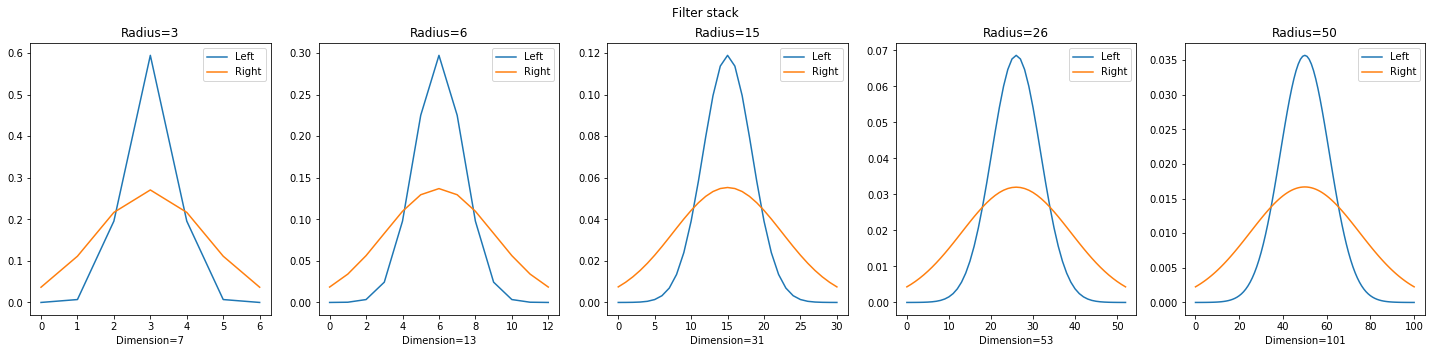

In [63]:
leftList, rightList  = generateSplitFilterStack(filterStack, 10)

def showSplitFilterStack(stackL, stackR): 
    f, axarr = plt.subplots(1, 5, figsize=(25,5))
    stackIdx = [2, 5, 14, 25, 49]
    for i in range(5):
        sl = stackL[stackIdx[i]]
        sr = stackR[stackIdx[i]]
        axarr[i].plot(sl, label="Left")
        axarr[i].plot(sr, label="Right")
        axarr[i].set_title("Radius=" + str(int(sl.shape[0]/2)))
        axarr[i].set_xlabel("Dimension=" + str(int(sl.shape[0])))
        axarr[i].legend()
    
    f.suptitle("Filter stack")
    plt.show()

showSplitFilterStack(leftList, rightList)

<div class="alert alert-warning" role="alert">
<b style="color:green;">&#9745;</b> <b>[3 Points]</b> Perform two passes of 1D convolution using your left and right singular vectors: here, you can rely on your `conv1d` and `transposeImage` implementations.
</div>

In [66]:
# inImage - Input image
# depthMap - depth map
# filterSize - maximimum length of filter
# leftList - list of left singular vectors
# rightList - list of right singular vectors
def conv2dSeparable(inImage, depthMap, filterSize, leftList, rightList):
    # Hint 0: Refer to code used in the earlier symmetric case, and
    # use the left and right filters appropriately as arguments to conv1d.
    # YOUR CODE HERE
    ih = conv1d(inImage, depthMap, 10, rightList)
    ihT = transposeImage(ih)
    ivT = conv1d(ihT, depthMap.T, 10, leftList)
    return transposeImage(ivT)
    # raise NotImplementedError()

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to test your implementation of `conv2dSeparable`. <i>Tip:</i> The difference image should be completely dark for a correct solution.
</div>

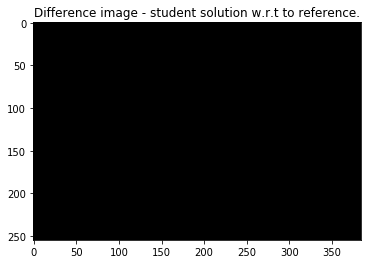

Test passed: congratulations!


In [67]:
@exit_after(9)
def testConv2dSeparable():
    # load an image and generate its depth map
    i0 = loadImage('Data/bokehCircular.jpg', 30)
    dM = generateDepthMap(i0.shape[1], i0.shape[0], 50, 25, 15, 20, 10)
    
    # load reference left and right singular vectors
    l0 = load('Data/uL.npz')
    l1 = load('Data/vL.npz')
    
    uL = [l0['u0'], l0['u1'], l0['u2'], l0['u3'], l0['u4'], l0['u5'], l0['u6'], l0['u7'], l0['u8'], l0['u9']]
    vL = [l1['v0'], l1['v1'], l1['v2'], l1['v3'], l1['v4'], l1['v5'], l1['v6'], l1['v7'], l1['v8'], l1['v9']]
    
    imConv = conv2dSeparable(i0, dM, 10, uL, vL)
    l0 = load('Data/t5.npz')
    
    diffIm = abs(l0['imC'] - abs(imConv))
    plt.imshow(uintImage(diffIm * 50))
    plt.title("Difference image - student solution w.r.t to reference.")
    plt.show()
    
    error = sqrt(sum(diffIm**2))
    denom = sqrt(sum(l0['imC']**2))
    return error / denom < 0.01
       
try:
    assert(testConv2dSeparable())
    print('Test passed: congratulations!')
except:
    raise Exception("est failed: your output differs too much from the reference.")

<div class="alert alert-info" role="alert">
 <b>Run</b> the following cell to compare the SVD approximation with the full, brute force spatially-varying 2D convolution.
</div>

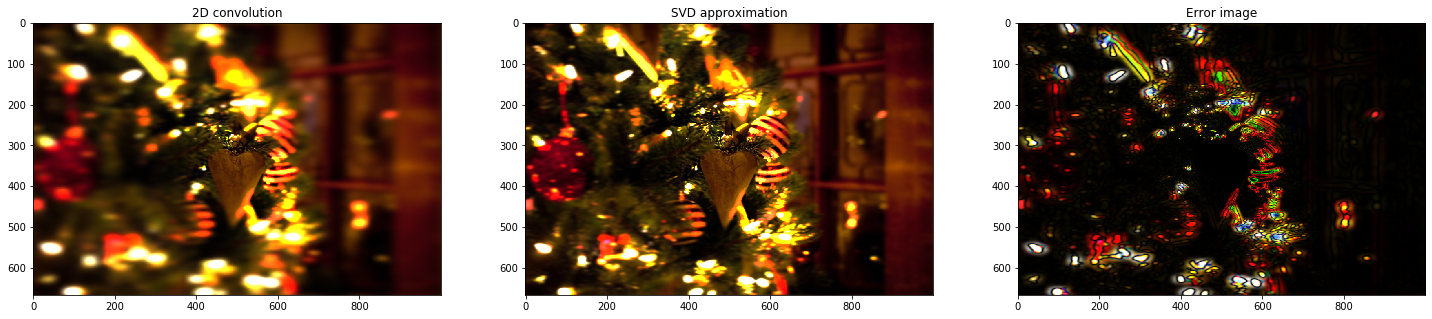

In [68]:
svdApprox = conv2dSeparable(imageSharpened, depthMap, filterRadius, leftList, rightList)

convImage = conv2d(imageSharpened, depthMap, filterRadius, filterStack)
f, axarr = plt.subplots(1, 3, figsize=(25,5))
axarr[0].imshow(uintImage(convImage))
axarr[0].set_title("2D convolution")
axarr[1].imshow(uintImage(abs(svdApprox)))
axarr[1].set_title("SVD approximation")
axarr[2].imshow(uintImage(abs(abs(svdApprox) - convImage)))
axarr[2].set_title("Error image")
plt.show()

## Bokeh DoF using real-world asymmetric filters **[15 points]**

We just approximated the spatially-varying 2D convolution of an asymmetric Gaussian kernel with two spatially-varying 1D kernel convolutions. You computed the necessary decomposition using a hand-crafted and specialized SVD that relied on power iteration.
Next, we'll apply the _same approximation_ to a more realistic base kernel: a star shape, which we encode in a bitmap image.

<div class="alert alert-info" role="alert">
Edit (optional) and <b>run</b> the following cell to change/set the base filter image.  
</div>

In [69]:
filterPath = "Data/Filters/star.jpg"

# Invert the intensities of filter image,
# i.e., bright becomes dark and vice versa
invertFilter = True # Invert the intensities of filter image i.e. bright becomes dark and vice versa

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to generate and display the filter stack for this base kernel.  
</div>

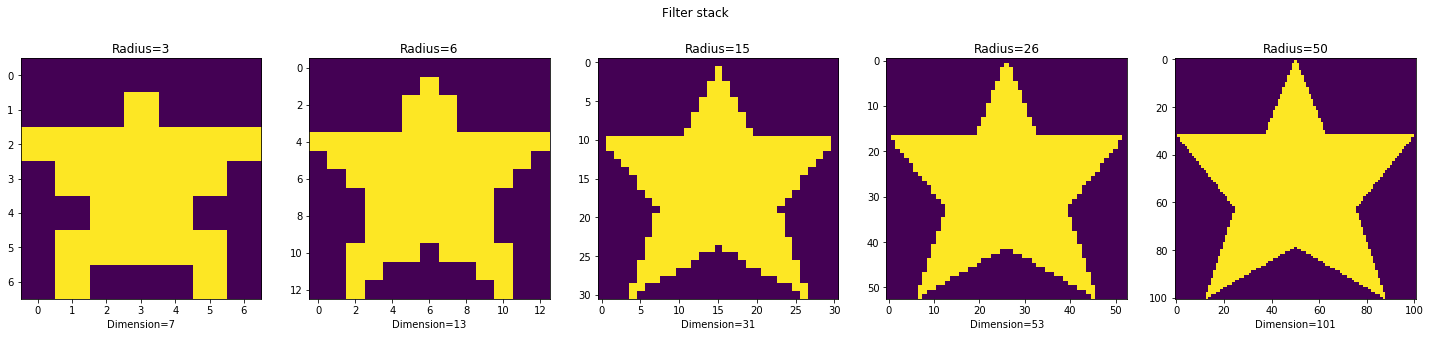

In [70]:
# Returns a list of filters of size 3 to (2 x maxFilterRadius + 1).
def loadFilterStack(path, maxRadius, invert, makeSymmetric):
    image = Image.open(path, mode = 'r')

    filters = []
    for radius in range(1, maxRadius + 1):
        resizedImg = image.resize((2*radius + 1, 2 * radius + 1), resample=Image.LANCZOS)
        rawData = array(resizedImg.getdata()).reshape(resizedImg.size[1], resizedImg.size[0], 3)
        rawData = rawData.astype(float)
        rawData = rawData / max(rawData)
        rawData = (rawData[:,:,0] + rawData[:,:,1] + rawData[:,:,2]) / 3.0
        rawData = round(rawData)
        if makeSymmetric:
            rawData = round(0.5 * (rawData + rawData.T))

        if invert:
            rawData = 1 - rawData
            filters.append(rawData/sum(rawData))
        else:
            filters.append(rawData/sum(rawData))

    return filters

filterStack = loadFilterStack(filterPath, maxFilterRadius, invertFilter, False)
showFilterStack(filterStack, False)

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to test your brute force implementation of `conv2d`. <i>Tip:</i> The difference image should be completely dark for a correct solution. 
</div>

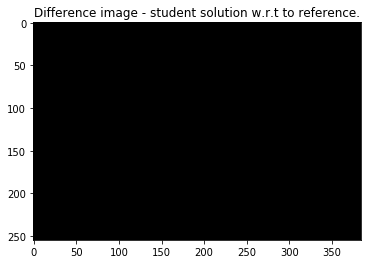

Test passed: congratulations!


In [71]:
# this is a test cell
@exit_after(10)
def testConv2d(testAbs : bool):
    # load an image, generate its depth map and 2D filter stack
    i0 = loadImage('Data/bokehCircular.jpg', 30)
    dM = generateDepthMap(i0.shape[1], i0.shape[0], 50, 25, 15, 20, 10)
    fMs = loadFilterStack("Data/Filters/star.jpg", 50, True, False)
    
    # run student code and compare to reference
    imConv = conv2d(i0, dM, 10, fMs)
    
    l0 = load('Data/t1.npz')
    diffIm = abs(l0['imC'] - imConv)
    plt.imshow(uintImage(diffIm * 50))
    plt.title("Difference image - student solution w.r.t to reference.")
    plt.show()
    
    if testAbs:
        return allclose(l0['imC'], imConv)
    
    error = sqrt(sum(diffIm**2))
    denom = sqrt(sum(l0['imC']**2))
    return error / denom < 0.07
    
try:
    assert(testConv2d(False))
    print('Test passed: congratulations!')
except:
    raise Exception("Test failed: your output differs too much from the reference.")

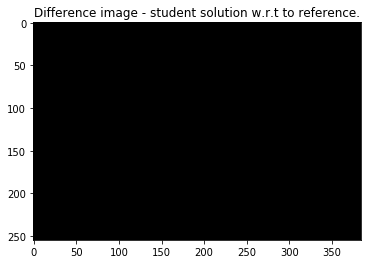

Perfect - all your pixels are a close match!


In [72]:
# this is a test cell
try:
    assert(testConv2d(True))
    print('Perfect - all your pixels are a close match!')
except:
    raise Exception("Pixels do not match closely with our solution.")

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to display the results of the brute force 2D convolution using the real-world filter stack.
</div>

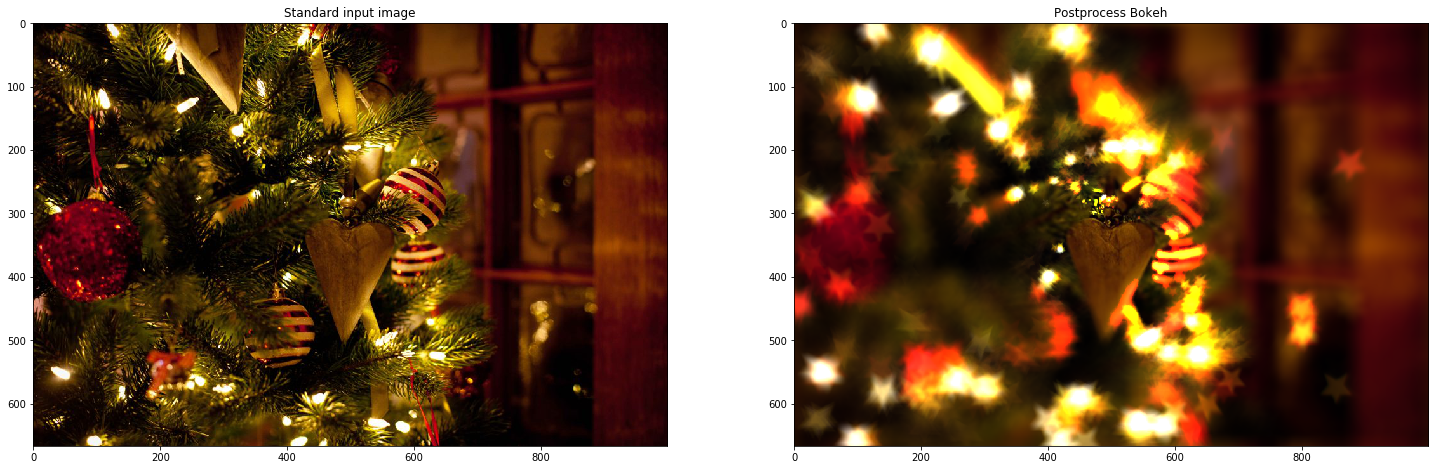

In [73]:
convImage = conv2d(imageSharpened, depthMap, filterRadius, filterStack)

f, axarr = plt.subplots(1, 2, figsize=(25,10))
axarr[0].imshow(image)
axarr[0].set_title("Standard input image")
axarr[1].imshow(uintImage(convImage))
axarr[1].set_title("Postprocess Bokeh")
plt.show()

Now that you've established a baseline solution, let's:
- perform a rank-1 decomposition of the realistic base kernel and create the associated 1D filter stack, and 
- use the approximate outer-product formulation to perform the 2 $\times$ 1D convolution trick.

While power iteration was handy for performing our simplified SVD in the presence of a single dominant singular value, it does not perform reliably for arbitray filters (i.e., with potentially many dominant modes.)

As such, we will instead rely on `numpy`'s implementation of SVD to obtain the first left and right singular vectors needed for our approximation.

<div class="alert alert-warning" role="alert">
 <b style="color:green;">&#9745;</b> <b>[15 Points]</b> Use `np.linalg.svd` to generate two seperate python lists of the first left and right singular vectors for each of the 2D filters in the filter stack. Be sure that every 1D kernel is normalized.
</div>

In [74]:
# stack2D - A list of 2D filters
# nIterations - Argument for powerIteration()
# return the list of left singular vectors followed by 
# the list of right singular vectors.
def generateSplitFilterStackNumpy(stack2D):
    # Hint 0: This function is very similar to generateSplitFilterStack
    # YOUR CODE HERE
    uL, vL = [], []
    for K in stack2D:
        P, D, Q = svd(K, full_matrices=False)
        idx = list(D).index(max(D))
        v = P[:, idx]
        u = Q[idx, :]
        u /= sum(abs(u))
        v /= sum(abs(v))
        uL.append(u)
        vL.append(v)
    return vL, uL
    # raise NotImplementedError()

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to test your implementation of `generateSplitFilterStackNumpy`. 
</div>

In [75]:
@exit_after(3)
def testGenerateSplitFilterStackNumpy():
    fMs = generateAsymGauss2DFilterStack(100, 0.5, 0.2)
    
    # run student code
    uL, vL = generateSplitFilterStackNumpy(fMs)
    
    if len(uL) != len(vL):
        print("Number of left and right filters must be equal.")
        return False
    
    if len(uL) != len(fMs):
        print("Number of left and right filters must be equal.")
        return False    
    
    for i in range(len(fMs)):
        if fMs[i].shape[0] != uL[i].shape[0]:
            print("Radius of left singular vector does not match the 2D filter radius.")
            return False
        if fMs[i].shape[0] != vL[i].shape[0]:
            print("Radius of right singular vector does not match the 2D filter radius.")
            return False
        
    l0 = load('Data/t4.npz')

    return allclose(l0['u73'], abs(uL[73])) and allclose(l0['v65'], abs(vL[65])) and allclose(l0['u0'], abs(uL[0])) and allclose(l0['v2'], abs(vL[2]))

try:
    assert(testGenerateSplitFilterStackNumpy())
    print('Perfect - generateSplitFilterStackNumpy works as expected!')
except:
    raise Exception("Test failed: your output did not match the reference solution.")

Perfect - generateSplitFilterStackNumpy works as expected!


<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to compare the SVD approximation with actual 2D convolution.
</div>

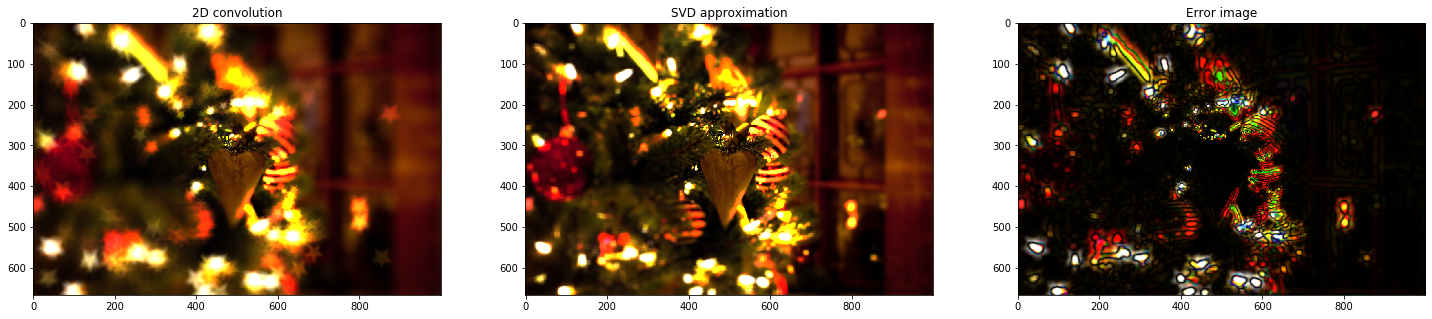

In [76]:
leftList, rightList = generateSplitFilterStackNumpy(filterStack)
svdApprox = conv2dSeparable(imageSharpened, depthMap, filterRadius, leftList, rightList)

f, axarr = plt.subplots(1, 3, figsize=(25,5))
axarr[0].imshow(uintImage(convImage))
axarr[0].set_title("2D convolution")
axarr[1].imshow(uintImage(abs(svdApprox)))
axarr[1].set_title("SVD approximation")
axarr[2].imshow(uintImage(abs(abs(svdApprox) - convImage)))
axarr[2].set_title("Error image")
plt.show()

# Deconvolution

If we "flatten" a 2D input image into a vector $\mathbf{x}$, we can express the brute force spatially-varying 2D convolution we performed above as a linear map:
$$
\mathbf{y} = \mathbf{G} \mathbf{x}
$$
where $\mathbf{G}$ is a matrix that encodes the convolution operation, $\mathbf{x}$ is our input image flattened into a vector, and $\mathbf{y}$ the output blurred image also in flattened form.


<div class="alert alert-warning" role="alert">
<b>[0 Points]</b> Think hard and try answering the following questions to better aprreciate the complexity disguised as a simple matrix-vector product in the above equation -
    <ul>
      <li>Given a single channel input image of size $m \times n$, what's the size of the vector $\mathbf{x}$?</li>
      <li>If we had to explicitly construct $\mathbf{G}$, what would each of its rows look like?</li>
      <li>Which part of the brute force convolution algorithm corresponds to the inner product between a row of $\mathbf{G}$ and $\mathbf{x}$?</li>
      <li>What is the size of $\mathbf{G}$ assuming a monochromatic image of size $m \times n$?</li>
      <li>How would you change $\mathbf{x}$ and/or $\mathbf{G}$ to accomodate the boundary padding?</li>
      <li>How would you change $\mathbf{x}$ and/or $\mathbf{G}$ to accomodate an RGB input and output?</li>
      <li> Assuming a 3-channel RGB image and 32-bit floating point values, how much storage is required for $\mathbf{G}$ for a 1080p image?</li>
      <li>Can you store $\mathbf{G}$ in RAM on your home computer/laptop?li>
      <li>If a single floating-point MAPP multiply/add operation take 1 $\mu\!\!$ s of time, how long would it take to explicitly compute $\mathbf{y}$ using a matrix-vector multiplication?</li>
    </ul>
</div>

One side-effect of explicitly expressing convolution as a linear transformation is that it allows us to reason about the (non-blind) _inverse deconvolution problem_: given a blurry output image $\mathbf{y}$ and a known convolution matrix $\mathbf{G}$, how can we recover the unblurred image $\mathbf{x}$?

Expressed as a solution to a least squares problem, we have
$$
\mathbf{x}_* = \argmin{\mathbf{x}} \underbrace{\norm{\mathbf{G}\mathbf{x} - \mathbf{y}}}_{E(\mathbf{x})}~.
$$

Let's begin by setting up our deconvolution inputs, by blurring our input image by an asymmetric 2D Gaussian and generating intermediate output for use later in the assignment.

<div class="alert alert-info" role="alert">
<b>Run</b> and edit (optional) the following cell to change the shape of our base kernel.
</div>

In [77]:
filterSkewFactor = 0.0 # Between -1 (max-skew) and 1 (max-skew)
filterDegenFactor = 0.2 # Between 0 (degenrate) and 1 (non-dengenerate)

<div class="alert alert-info" role="alert">
<b>Run</b> the following cell to create our blur image, and the filter stacks needed for the deconvolution tasks to follow.
</div>

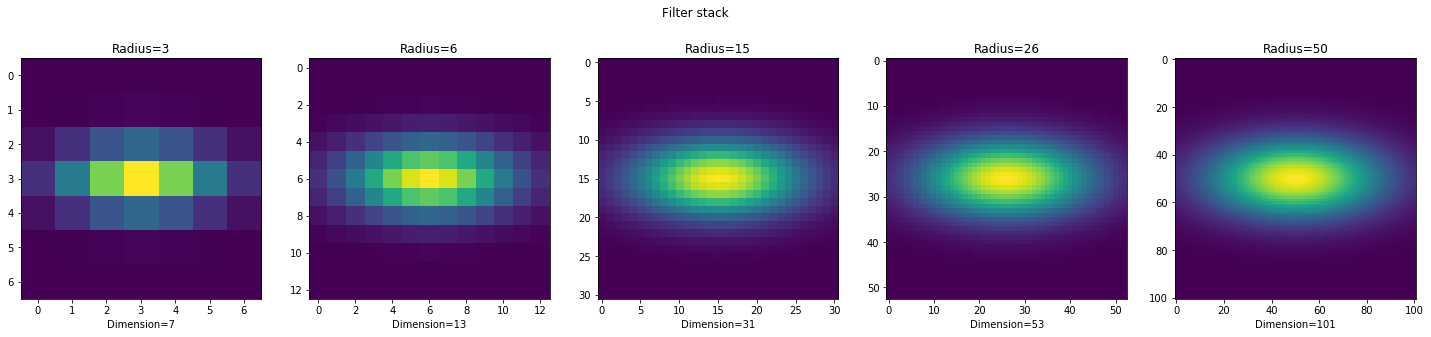

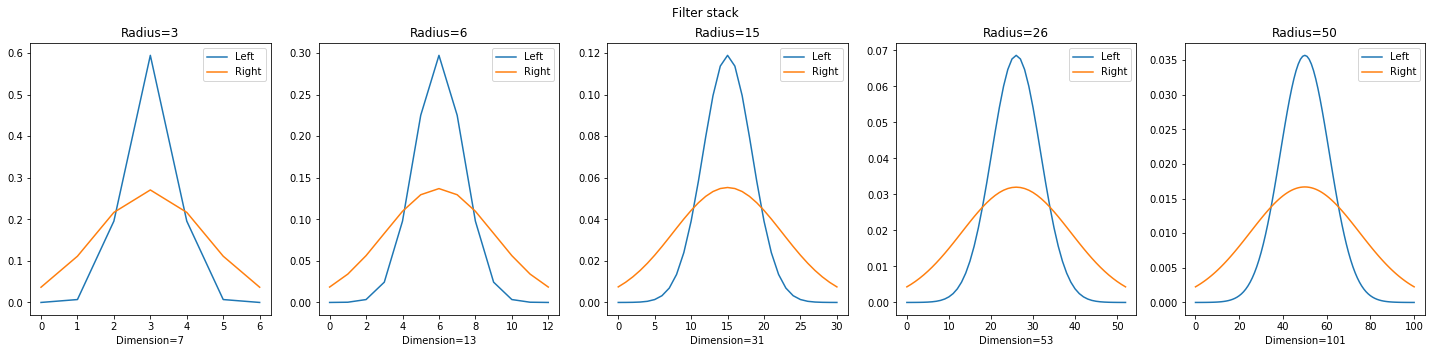

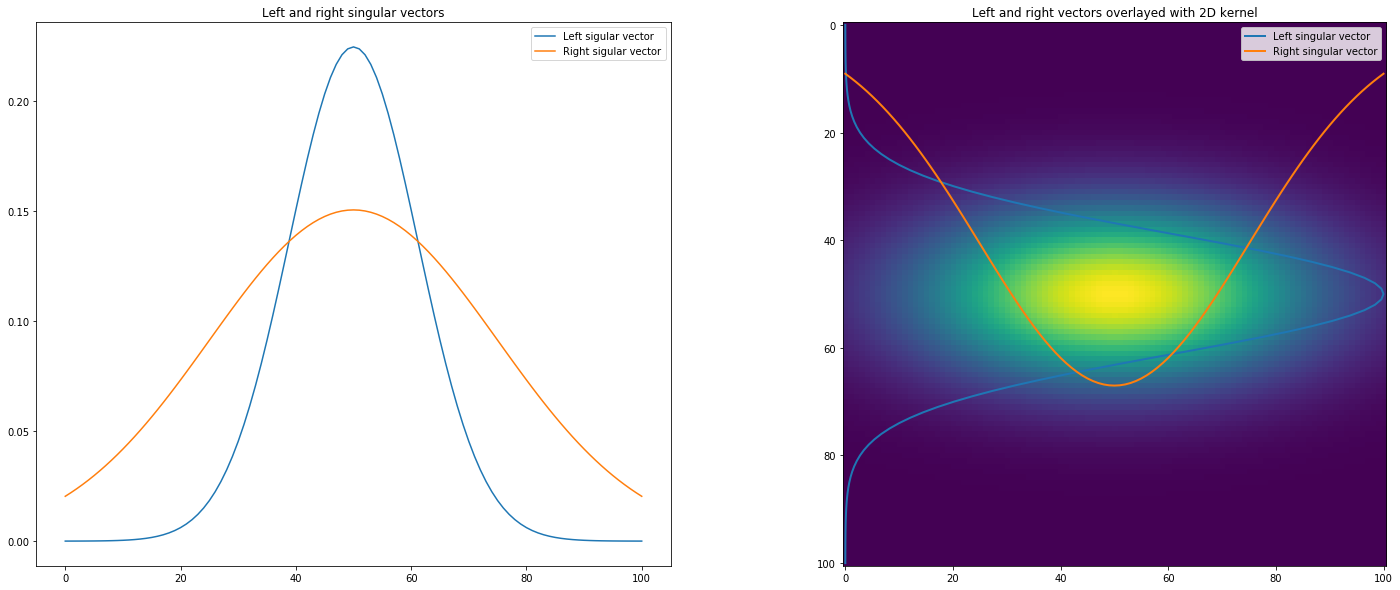

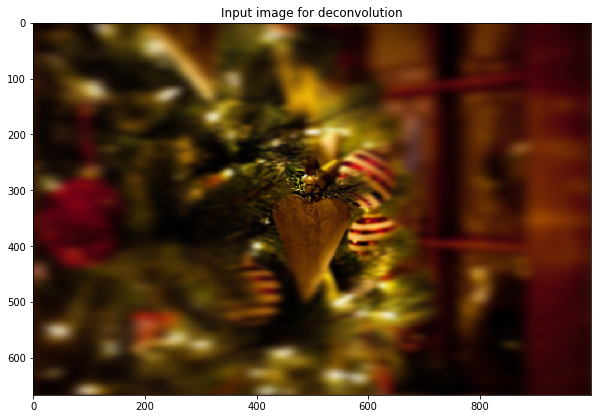

In [78]:
filterStack = generateAsymGauss2DFilterStack(maxFilterRadius, filterSkewFactor, filterDegenFactor)
showFilterStack(filterStack, False)


leftList, rightList  = generateSplitFilterStack(filterStack, 20)
showSplitFilterStack(leftList, rightList)

f, axarr = plt.subplots(1, 2, figsize=(25,10))
axarr[0].plot(leftSingular, label="Left sigular vector")
axarr[0].plot(rightSingular, label="Right sigular vector")
axarr[0].set_title("Left and right singular vectors")
axarr[0].legend()
axarr[1].imshow(gauss2DFilter)
f.canvas.draw()
maxOfTwo = max(array([max(leftSingular), max(rightSingular)]))
axarr[1].plot(leftSingular / maxOfTwo * maxFilterRadius * 2, label="Left singular vector", linewidth=2)
f.canvas.draw()
newx = axarr[1].lines[0].get_ydata()
newy = axarr[1].lines[0].get_xdata()
axarr[1].lines[0].set_xdata(newx)
axarr[1].lines[0].set_ydata(newy)
axarr[1].plot(rightSingular / maxOfTwo * maxFilterRadius * 2, label="Right singular vector", linewidth=2)
axarr[1].legend()
axarr[1].set_title("Left and right vectors overlayed with 2D kernel")
plt.show()

convImage = conv2d(image, depthMap, filterRadius, filterStack)
plt.figure(figsize=(10,10))
plt.imshow(uintImage(convImage))
plt.title("Input image for deconvolution")
plt.show()

For large images, inverting $\mathbf{G}$ or computing a suitable decomposition can be too costly. We will instead employ the steepest (gradient) descent algorithm to solve our least squares problem.

To do so, we need to be able to compute the gradient of our error function $E(\mathbf{x})$ and evaluate it at every iteration of the descent. For the $k^{th}$ steepest descent iteration, this is given by
$$
\frac{\partial E(\mathbf{x})}{\partial \mathbf{x}}\bigg|_{\mathbf{x}_k} = -2 \mathbf{G}^T(\mathbf{y} - \mathbf{G}\mathbf{x}_k),
$$
where $\mathbf{x}_k$ is the estimate of the deconvolved image at the $k^{th}$ iteration.

Unfortunately, we do not want to explicitly form the matrix $\mathbf{G}$ (it's too big!). And so, the challenge lies in efficiently evaluating ${\partial E(\mathbf{x})}\big/{\partial \mathbf{x}}$ at $\mathbf{x}_k$ every iteration, without forming $\mathbf{G}$.

<!--**Computing the Gradient**-->

We can boil this problem down to two steps:

**Step 1 - Convolution** 

Computing the bracketed term
$$ 
\mathbf{z}_k = \mathbf{y} - {\mathbf{G}\mathbf{x}_k}
$$
effectively boils down to computing the forward (blurring) process, e.g., with `conv2d` and subtracting from the original blurred input.

**Step 2 - Splatting**

Afterwards, you need to compute
$$
\frac{\partial {E}(\mathbf{x})}{\partial \mathbf{x}}\bigg|_{\mathbf{x}_k} = -2 {\mathbf{G}^T \mathbf{z}_k}~,
$$
however, without explicitly forming $\mathbf{G}^T$ nor performing any matrix-vector multiplication.

<!--
$$
G^Tr = g_0 r_0 + g_1 r_1 +...+ g_{mn}r_{mn}
$$

where,

* $g_i$ - is the $i^{th}$ columns of $G^T$ or eqivalently the $i^{th}$ rows of G,
* $r_i$ - is the $i^{th}$ scalar components of vector r.

The following illustrates the splat operation.

<img src="kernelSplat.png" width="90%"/>
-->

<div class="alert alert-warning" role="alert">
<b style="color:green;">&#9745;</b> <b>[25 Points]</b> Complete the implementation of the `computeGradient` function, according to the specifications above, in the cell below.
</div>    

In [84]:
#Hint 0: Add helper functions if required. Make sure the name of your function does not interfere with any other functions used above.

# YOUR CODE HERE
# raise NotImplementedError()

# iPad - Current estimate of the deblurred image
# iBlur - Blurred image
# depthMap, maxFilterRadius - for use with getFilterRadius to query the filter radius for pixel (i,j)
# filters - list containing filter mips of radius 1 to 50
# maxFilterRadius - Use maxFilterRadius as an argument to getFilterRadius() to query filter radius at pixel (i,j) 
# return the gradient evaluated at 
def computeGradient(iPad, iBlur, depthMap, filters, maxFilterRadius):
    (imH, imW, _) = iBlur.shape
    dEdx = zeros(iPad.shape)
  
    # YOUR CODE HERE
    mod_img = conv2d(iBlur, depthMap, 10, filters)
    filT = [f.T for f in filters]
    z = transposeImage(iBlur - mod_img)

    dEdx = conv2d(z, depthMap.T, 10, filT)
    dEdx = pad(dEdx, ((10, 10), (10, 10), (0, 0)), 'median')
    dEdx = transposeImage(dEdx)
    # raise NotImplementedError()

    return -2 * dEdx

<div class="alert alert-info" role="alert">
<b>Run</b> the <i>two</i> following cells to test your implementation of `computeGradient`. <i>Tip:</i> The difference image should be completely dark for a correct solution.
</div>

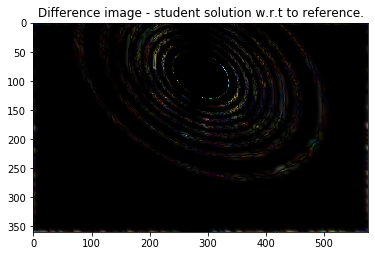

Test passed: congratulations!


In [100]:
@exit_after(25)       #Modification 1
def testComputeGradient(fs, epsilon, inFile):
    iBlur = load('Data/t6.npz')['imC']
    
    # generate depth map and filter stack
    dM = generateDepthMap(iBlur.shape[1], iBlur.shape[0], 50, 25, 15, 20, 10)
    fMs = generateAsymGauss2DFilterStack(fs, 0.5, 0.2)
    
    (imH, imW, channel) = iBlur.shape
    imagePad = zeros((imH + 2 * fs, imW + 2 * fs, channel))
    imagePad[:,:,0] = pad(iBlur[:,:,0], ((fs, fs), (fs, fs)), 'median' )
    imagePad[:,:,1] = pad(iBlur[:,:,1], ((fs, fs), (fs, fs)), 'median' )
    imagePad[:,:,2] = pad(iBlur[:,:,2], ((fs, fs), (fs, fs)), 'median' )
            
    # evaluate code and compare to reference
    dEdx = computeGradient(imagePad, iBlur, dM, fMs, fs)[fs : imH + fs, fs : imW + fs]
    
    l0 = load(inFile)  #Modification 2
    img_ref = l0['dfx'][fs : imH + fs, fs : imW + fs]    #Modification 3
    
    diffIm = abs(img_ref - dEdx)
    plt.imshow(uintImage(diffIm * 50))
    plt.title("Difference image - student solution w.r.t to reference.")
    plt.show()
        
    error = sqrt(sum(diffIm**2))
    denom = sqrt(sum(img_ref**2))
   
    return error / denom < epsilon

try:
    assert(testComputeGradient(10, 0.07, 'Data/t6o.npz'))
    print('Test passed: congratulations!')
except:
    raise Exception("Test failed: your output differs too much from the reference.")

In [82]:
@exit_after(20)
def testComputeGradient(fs, epsilon, inFile):
    iBlur = load('Data/t6.npz')['imC']
    
    # generate depth map and filter stack
    dM = generateDepthMap(iBlur.shape[1], iBlur.shape[0], 50, 25, 15, 20, 10)
    fMs = generateAsymGauss2DFilterStack(fs, 0.5, 0.2)
    
    (imH, imW, channel) = iBlur.shape
    imagePad = zeros((imH + 2 * fs, imW + 2 * fs, channel))
    imagePad[:,:,0] = pad(iBlur[:,:,0], ((fs, fs), (fs, fs)), 'median' )
    imagePad[:,:,1] = pad(iBlur[:,:,1], ((fs, fs), (fs, fs)), 'median' )
    imagePad[:,:,2] = pad(iBlur[:,:,2], ((fs, fs), (fs, fs)), 'median' )
            
    # evaluate code and compare to reference
    dEdx = computeGradient(imagePad, iBlur, dM, fMs, fs)[fs : imH + fs, fs : imW + fs]
    l0 = load(inFile)
    diffIm = abs(l0['dfx'] - dEdx)
    plt.imshow(uintImage(diffIm * 50))
    plt.title("Difference image - student solution w.r.t to reference.")
    plt.show()
        
    error = sqrt(sum(diffIm**2))
    denom = sqrt(sum(l0['dfx']**2))
   
    return error / denom < epsilon

try:
    assert(testComputeGradient(10, 0.07, 'Data/t6o.npz'))
    print('Test passed: congratulations!')
except:
    raise Exception("Test failed: your output differs too much from the reference.")

testComputeGradient took too long


Exception: Test failed: your output differs too much from the reference.

In [93]:
try:
    assert(testComputeGradient(5, 0.01, 'Data/t7.npz'))
    print('Test passed: congratulations!')
except:
    raise Exception("Test failed: your output differs too much from the reference.")

Exception: Test failed: your output differs too much from the reference.

<div class="alert alert-info" role="alert">
<b>Run</b> and edit (optional) the following cell to change the parameters for the steepest descent algorithm we provide.
</div>

In [97]:
steepestDescentStepSize = 0.4
steepestDescentIterations = 5

<div class="alert alert-info" role="alert">
<b>Run</b> steepest descent, which relies on your `computeGradient` routine.
</div>

In [98]:
def steepestDescent(iBlur, depthMap, kernels, maxKernelRadius, stepSize, iterations, referenceImage):
    (imH, imW, channel) = iBlur.shape
    imagePad = zeros((imH + 2 * maxKernelRadius, imW + 2 * maxKernelRadius, channel))
    imagePad[:,:,0] = pad(iBlur[:,:,0], ((maxKernelRadius, maxKernelRadius), (maxKernelRadius, maxKernelRadius)), 'median' )
    imagePad[:,:,1] = pad(iBlur[:,:,1], ((maxKernelRadius, maxKernelRadius), (maxKernelRadius, maxKernelRadius)), 'median' )
    imagePad[:,:,2] = pad(iBlur[:,:,2], ((maxKernelRadius, maxKernelRadius), (maxKernelRadius, maxKernelRadius)), 'median' )

    for i in range(iterations):
        dEdx = computeGradient(imagePad, iBlur, depthMap, kernels, maxKernelRadius)
        imagePad -= stepSize * dEdx
        f, axarr = plt.subplots(1, 3, figsize=(25,5))
        axarr[0].imshow(uintImage(referenceImage))
        axarr[0].set_title("Reference")
        axarr[1].imshow(uintImage(iBlur))
        axarr[1].set_title("Blurred image")
        axarr[2].imshow(uintImage(imagePad[maxKernelRadius : maxKernelRadius + imH, maxKernelRadius : maxKernelRadius + imW]))
        axarr[2].set_title("De-blurr image, Iteration:" + str(i))
        f.suptitle("Gardient magnitude:{:10.4f}".format(sqrt(sum(dEdx**2))))
        plt.show()
 
    return imagePad[maxKernelRadius : maxKernelRadius + imH, maxKernelRadius : maxKernelRadius + imW]

deconvImage = steepestDescent(convImage, depthMap, filterStack, filterRadius, steepestDescentStepSize, steepestDescentIterations, image)

ValueError: operands could not be broadcast together with shapes (717,1050,3) (687,1020,3) (717,1050,3) 